# Table of Contents
##### 1) Problem Statement
##### 2) Data Analysis Preparation
>     A) Evaluate Computational Efficiency
>     B) Load Packages
>     C) Load Data
>     D) Preprocess and Clean Data
##### 3) Exploratory Data Analysis (EDA)
>     A) Insights from preliminary EDA
>     B) Create TensorFlow Dataset
>     C) Comparison of preliminary and final EDA
>     D) Visualization of fMRI data
##### 4) Convolutional Neural Networks
>     A) Model 1: Standard (Vanilla)
>     B) Model 2: Standard + Google Brain (Strawberry)
>     C) Model 3: Auto-encoder + Google Brain (Chocolate)
##### 5) Transfer Learning
>     A) Best fitting model
>     B) VGG-16
>     C) GoogLeNet (Inception-V3)
##### 6) Ensemble Model
##### 7) Best Fitting Model - Saliency Map
##### 8) Future Directions (+ Extras)
##### 9) Summary 
##### 10) References

## Problem Statement

### Goal: Train a Convolutional Neural Network (CNN) to classify the presence of tumors in fMRI brain images. 

Malignant brain tumors are relatively rare, but they account for a disproportionate number of cancer-related mortalities due to their low survival rate – only 1/3 of individuals survive 5+ years post-diagnosis (Miller et al., 2021).Therefore, identifying brain abnormalities as soon as possible is paramount for increasing a patient’s potential for survival. However, brain tumors are incredibly complex and difficult to diagnose. Beyond requiring functional magnetic resonance imaging (fMRI) to visualize and diagnose brain tumors, a professional neurosurgeon is usually required to interpret the output of MRI analysis. This challenge is in part due to large amounts of variation among the potential size and locations of brain tumors. Moreover, the degree of educational specialization required to become a neurosurgeon poses a significant obstacle for diagnosing brain tumors in developing countries. In sum, a new approach for diagnosing malignant brain tumors is necessary which circumvents the need for advanced medical training while prioritzing speed and accuracy.

### Data:
To train and evaluate my convolutional neural network I will leverage 2 distinct datasets:

 1) A dataset from $figshare.com$ containing 3064 T1-weighted contrast-inhanced images with three kinds of brain tumor: meningioma (708 images), glioma (1426 images), and pituitary tumor (930 images). 
 
Note: Due to the large file size, the authors split the dataset into 4 subsets, and archived them into 4 .zip files with each containing 766 brain 'slices'.
 
This dataset is freely available here:
https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

 2) A dataset from $kaggle.com$ including 3000 total images of 1500 healthy brains, and 1500 brains with tumors.

Note: This dataset ('Br35H') is associated with a Kaggle competition for identifying tumors in neuroimaging data and is split into two different folders indicating whether a tumor was present ('yes' & 'no').

This dataset is freely available here:
https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no

##  Data Analysis Preparation

### Evaluate the Efficiency of Computer Processing 

In [1]:
#Evaluate GPU information to ensure we are using GPUs for processing efficiency
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0: #Add flag in case no GPU located
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  8 19:04:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Our computational hardware includes Tesla T4 GPUs which indicates our processing will be hyper-efficient.

### Load Packages

In [2]:
#Load Packages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*TensorFlow Addons.*')
from glob import glob
import pandas as pd
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, TimeDistributed, LSTM, Lambda, Conv2DTranspose, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Layer
from tensorflow.keras.models import Model, load_model
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow_addons as tfa
from tensorflow.python.profiler import profiler_client
import tensorboard
import visualkeras
import json

/opt/conda/envs/cs109b/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Load Data

In [3]:
#Define paths to folders in Harvard Jupyterhub
# Brain Tumor Dataset ~ .mat format
d1_path = './brainTumorDataPublic_1-766/'
d2_path = './brainTumorDataPublic_767-1532/'
d3_path = './brainTumorDataPublic_1533-2298'
d4_path = './brainTumorDataPublic_2299-3064/'

# Kaggle data ~ .jpeg format
path_no = './no/'
path_yes = './yes/'

### Preprocess and Clean Data

In [4]:
## Loading: Tumor Dataset ##
# Note: the .mat files cannot be loaded with scipy because of format they were saved in // using h5py instead
def clean_tumor(set):
    #Define paths and files in folder
    paths = [d1_path, d2_path, d3_path, d4_path]
    set_path = paths[set]
    files = glob(set_path + '*.mat')

    data = []
    #Read in images after data is identified
    for file_path in files:
        with h5py.File(file_path, 'r') as f:
            #Access fields of MatLab struct object
            struct_obj = f['cjdata']
            PID = int(struct_obj['PID'][0][0]) #Matlab structured object, so double nested indexing necessary
            label = int(struct_obj['label'][0][0]) #Matlab structured object, so double nested indexing necessary
            img_dat = np.array(struct_obj['image'])
            tum_bord = np.array(struct_obj['tumorBorder'])
            tum_mask = np.array(struct_obj['tumorMask'])
            #Convert data to list of dicts
            data.append({
                'PID': PID,
                'label': label,
                'img_dat': img_dat,
                'tum_bord': tum_bord,
                'tum_mask': tum_mask
            })
#Create pandas dataframe from list of dicts
    df = pd.DataFrame(data)
    return df

## Loading: Kaggle Datset ##
def clean_kaggle(set):
    #Define paths and files in folder
    paths = [path_no, path_yes]
    set_path = paths[set]
    files = [set_path+x for x in os.listdir(set_path)]

    data = []
    #Read in images after files are identified
    for id, file_path in enumerate(files):
        #Load images using OpenCV
        img = cv2.imread(file_path)
        #Extract patients ID and labels
        label = set_path.split('/')[-2]
        PID = files[id].split('/')[-1].split('.jpg')[-2].strip(str(label))
        #Append data to list as dictionary
        data.append({
            'PID': PID,
            'label': label,
            'img_dat': img
        })
    #Create pandas dataframe from list of dicts
    df = pd.DataFrame(data)
    return df

In [5]:
#Extract Figshare Tumor Data
tum_1 = clean_tumor(0)
tum_2 = clean_tumor(1)
tum_3 = clean_tumor(2)
tum_4 = clean_tumor(3)

#Combine Figshare Tumor Data
tmr_full = pd.concat([tum_1, tum_2, tum_3, tum_4], axis=0)

In [6]:
#Extract Kaggle Data
kg_no = clean_kaggle(0)
kg_yes = clean_kaggle(1)

#Combine Kaggle Data
kg_full = pd.concat([kg_yes, kg_no], axis=0)

In [7]:
#Evaluate the dimensions of the created dataframes
# Figshare (Tumor) data
print(f"The dimensions of the Tumor dataset photos are {tum_1['img_dat'].iloc[0].shape}")
print(f"The dimensions of the Tumor dataset photos are {tum_2['img_dat'].iloc[0].shape}")
# Kaggle (Tumor // Healthy) Data
print(f"The dimensions of the Kaggle dataset 'yes' photos are {kg_yes['img_dat'].iloc[0].shape}")
print(f"The dimensions of the Kaggle dataset 'no' photos are {kg_no['img_dat'].iloc[0].shape}")\

#Takeaway
print('')
print('Based on the mismatched dimensions above, I chose to resize all images to 256x256, and normalized pixel value intensities across the images before conducting an exploratory data analysis. I also enforced equivalence across the number of channels in both datasets by making them both greyscale.')

The dimensions of the Tumor dataset photos are (512, 512)
The dimensions of the Tumor dataset photos are (512, 512)
The dimensions of the Kaggle dataset 'yes' photos are (234, 216, 3)
The dimensions of the Kaggle dataset 'no' photos are (252, 200, 3)

Based on the mismatched dimensions above, I chose to resize all images to 256x256, and normalized pixel value intensities across the images before conducting an exploratory data analysis. I also enforced equivalence across the number of channels in both datasets by making them both greyscale.


# Exploratory Data Analysis

### Insights from preliminary EDA

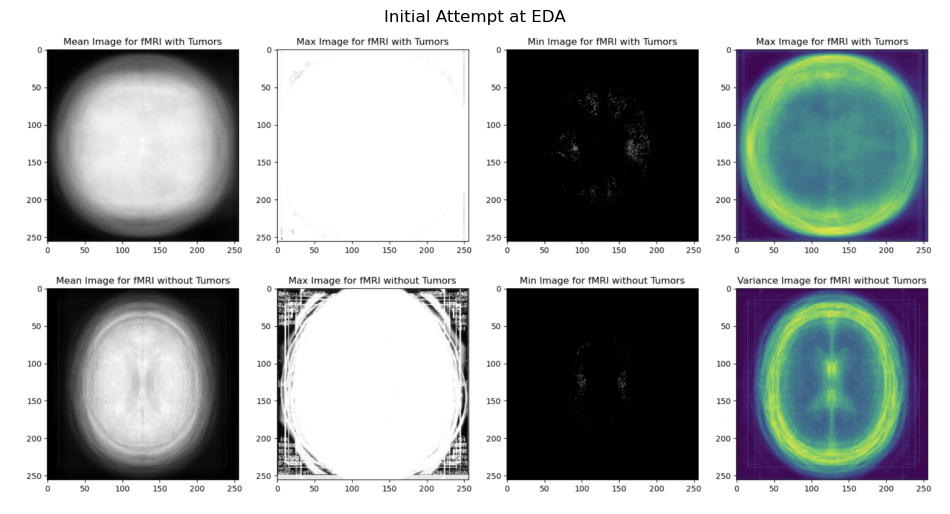

In [8]:
#Visualize preliminary EDA
EDA_img = plt.imread('EDA_Fail.png')
fig = plt.figure(figsize=(12,10)) #Create new figure
plt.title('Initial Attempt at EDA') #Add title to plot
plt.imshow(EDA_img)
plt.axis('off') #Remove the axes
plt.show(); #Display image on figure

Our initial attempt at EDA was enlightening as it highlighted several potential issues with our data.

The main four -- highlighted in the plot above were:

1) For fMRI images of brains with tumors (top row), certain brains were in different orientations (ie. offset by 90 degrees).

In our second EDA we resolved issue #1 by rotating the images that were offset by 90 degrees to align them with the majority of the fMRI data.

2) Another issue with the fMRI images of brains with tumors was that there were different planar views (axial, sagittal, coronal) of the brain in the 'FIGSHARE' dataset -- which may lead to issues with generalization as different planes of the brain emphasize different anatomical landmarks.

We resolved issue #2 by manually examining the 'FIGSHARE' dataset and including only brains in an axial view, to better align with data from the Kaggle dataset.

3) For fMRI images of brains without tumors (bottom row), some images had artifacts relating to their image border.

We resolved issue #3 by removing a small amount of space from each of the image borders in the fMRI dataset without tumors, BEFORE padding to align with the size of the rest of the images in our dataset.

4) Among all the images, there was small variations with regard to brain orientation - as can be observed by the noisy borders in the variance image of the brains.

We resolved issue #4 by using data augmentation techniques to rotate training images by a small amount (~9 degrees) in order to increase the generalization of our model to slightly rotated brains.

These solutions are elaborated in depth below.

#### EDA Issue #3 Solution: As the image shows, our fMRI images without tumors have artifacts in the images such as borders and annotations in the image corners. Given that image classification emphasizes searching for patterns of pixels, these artifacts being unique to fMRI images without tumors may facilitate our convolutional neural network focusing on these trivial patterns instead of searching for tumors in fMRI images. Therefore, edge deletion was completed so pixels were removed from edges where issues arose -- resulting in 20 rows of horizontal pixels being deleted, and 10 rows of vertical pixels being deleted. The images were then repadded to their intended size. After this was completed, we realized there were still remaining artifacts at the image corners. Specifically, deleting the edges of images removed the border artifacts, but not the annotations in the corners of the images -- so we applied a simple function to delete image corner pixels depending on a diagonal triangular base size specified by the user. The images were then padded once more in order to enforce equality in dimension sizes across all images.

In [9]:
def preprocess_image(img_data, new_size=(256, 256)):
    #Convert to grayscale (if necessary); checks for channels and alters if RGB
    if len(img_data.shape) == 3 and img_data.shape[2] == 3:
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    img_data = cv2.resize(img_data, new_size) #Resize image
    img_arr = img_data.astype('float32') / np.max(img_data) #Convert image to array and normalize pixel values
    img_arr = img_arr.reshape((*new_size, 1)) #Reshape to single channel dimension
    return img_arr

def delete_corner_pixels(img, corner_size):
    #Delete the pixels at the corners of each image (by setting them to 0) depending on the size specified by user to create mask
    h, w = img.shape[:2] #Determine current image size
    #Loop through corners and zero out pixels depending on size specified
    for i in range(corner_size):
        img[i, :corner_size-i] = 0  #Top-left corner
        img[i, w-corner_size+i:] = 0  #Top-right corner
        img[h-i-1, :corner_size-i] = 0  #Bottom-left corner
        img[h-i-1, w-corner_size+i:] = 0  #Bottom-right corner
    return img

def pad_image(img, target_size):
    #Pads image with zeroes in order to ensure that all photos are the same size after cropping has completed
    h, w = img.shape[:2] #Determine current image size
    pad_h = target_size[0] - h #Determine padding needed for top & bottom
    pad_w = target_size[1] - w #Determine padding needed for left & right
    #Create border with padding determined above and apply
    top_pad = max(pad_h//2, 0)
    bottom_pad = max(pad_h - pad_h//2, 0)
    left_pad = max(pad_w//2, 0)
    right_pad = max(pad_w - pad_w//2, 0)
    return cv2.copyMakeBorder(img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)

def image_padr(img, target_size, corner_size):
    #Combines all functions dealing with cropping and padding into single function
    h, w = img.shape[:2] #Get image shape
    img = img[20:h-20, 10:w-10] #Delete pixels on outside borders
    img = pad_image(img, target_size) #Pad images for the 1st time
    img = delete_corner_pixels(img, corner_size) #Delete corner pixels
    img = pad_image(img, target_size) #Pad image for the 2nd time
    
    return img

def img_df_cleaner(df, img_col, corner_size, new_size=(256, 256)):
    #Iterate over dataframe and complete preprocessing on each image
    img_list = []
    for i, row in df.iterrows():
        img_data = row[img_col]
        img_data = image_padr(img_data, new_size, corner_size)
        img_arr = preprocess_image(img_data, new_size=new_size)
        img_list.append(img_arr)
    return img_list

In [10]:
#Preprocess images in kaggle dataset
kg_full['img_arr'] = img_df_cleaner(kg_full, 'img_dat', new_size=(256, 256), corner_size = 95)
#Preprocess images in tumor dataset
tmr_full['img_arr'] = img_df_cleaner(tmr_full, 'img_dat', new_size=(256, 256), corner_size = 30)

In [11]:
#Verify that pixels were normalized correctly
index = 56 #Chosen index from kg_full dataset

#Extract original and preprocessed images
original_image = kg_full.iloc[index]['img_dat']
preprocessed_image = kg_full.iloc[index]['img_arr']

#Print pixel values for the original and preprocessed image
print("Original pixel values:")
print(original_image)
print('')
print("Preprocessed (normalized) pixel values:")
print(preprocessed_image)

Original pixel values:
[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 5  5  5]
  [ 4  4  4]
  [ 6  6  6]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 1  1  1]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 1  1  1]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 3  3  3]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 4  4  4]]

 [[ 1  1  1]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 4  4  4]
  [ 6  6  6]
  [14 14 14]]]

Preprocessed (normalized) pixel values:
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


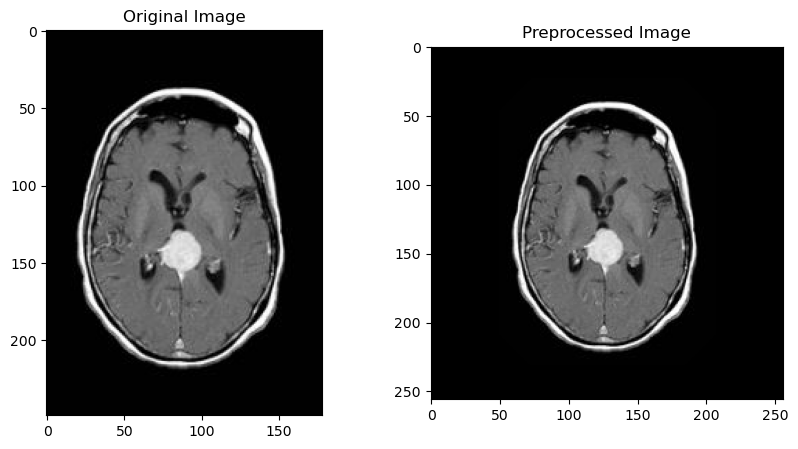

In [12]:
#Visual inspection (Sanity Check) ~ Preprocessing
index = 89 #index image
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) #Create figure with two subplots
#Display original image 
axs[0].imshow(kg_full.iloc[index]['img_dat'])
axs[0].set_title("Original Image")
#Display  preprocessed image
axs[1].imshow(kg_full['img_arr'].iloc[index], cmap='gray')
axs[1].set_title("Preprocessed Image");

It is apparent from this visualization that our preprocessing proceded correctly -- turning the rectangular images of brains into squares and centering the brains in the center of images. We will later verify the artifacts identified during our preliminary EDA were dealt with appropriately.

#### EDA Issue #2 Solution: We expected all fMRI images of brains to be captured in a consistent planar orientation, but upon closer inspection there were various brain orientations. Specifically, there are three possible planar orientations that images can be taken from in a fMRI machine: Axial, Sagittal, and Coronal. Although all our Kaggle images were in Axial orientation, the Figshare dataset came with all three orientations. This may cause severe issues with training because the different orientations of images reveal distinct anatomical landmarks. As a result, training can suffer as the network may fail to delineate consistencies amongst brain tissue when comparing to abnormal tumor growth. Therefore I manually iterated through all the images and selected only images taken from axial views to align with our data from the Kaggle dataset. This left 589 images from Figshare.com -- making our total dataset 2089 images of brains with tumors and 1500 images of healthy brains.

In [13]:
#Specify the brain images (indexes) taken from an axial orientation
axial_view_tmr = [0, 4, 8, 11, 16, 19, 20, 23, 24, 34, 44, 48, 52, 53, 55, 57, 61, 63, 64, 67, 72, 73, 74, 75, 78, 81, 84, 87, 88, 
 90, 94, 98, 101, 105, 107, 110, 111, 113, 117, 122, 125, 129, 132, 135, 139, 142, 146, 148, 150, 151, 154, 162, 
 163, 166, 168, 170, 179, 183, 184, 187, 190, 194, 197, 205, 209, 212, 219, 223, 225, 228, 229, 230, 233, 237, 239,
 241, 243, 245, 251, 254, 255, 256, 257, 258, 265, 268, 269, 272, 273, 276, 281, 285, 286, 288, 289, 292, 296, 300,
 301, 303, 309, 311, 314, 316, 318, 320, 321, 329, 331, 335, 337, 346, 349, 351, 361, 364, 366, 367, 376, 379, 382,
 389, 392, 401, 407, 412, 413, 414, 416, 420, 424, 426, 429, 430, 436, 437, 438, 442, 448, 449, 453, 454, 459, 460,
 461, 463, 465, 468, 469, 471, 475, 477, 480, 482, 486, 488, 493, 495, 496, 497, 499, 501, 503, 505, 508, 511, 517,
 520, 524, 528, 532, 534, 540, 541, 544, 549, 555, 556, 560, 564, 565, 571, 576, 578, 586, 591, 593, 594, 596, 597,
 600, 601, 603, 607, 612, 614, 617, 618, 620, 625, 626, 627, 631, 632, 640, 642, 643, 647, 648, 649, 651, 655, 656,
 657, 662, 665, 671, 674, 675, 676, 685, 687, 691, 692, 693, 695, 698, 699, 700, 707, 709, 711, 715, 718, 723, 725,
 730, 732, 739, 744, 746, 753, 758, 760, 768, 769, 771, 775, 780, 781, 785, 787, 789, 792, 793, 797, 800, 806, 808,
 813, 816, 817, 820, 822, 823, 826, 827, 832, 834, 837, 841, 844, 846, 850, 852, 854, 858, 861, 863, 866, 867, 871,
 873, 876, 877, 878, 879, 881, 882, 886, 888, 891, 892, 894, 899, 903, 905, 906, 909, 911, 915, 918, 920, 929, 933,
 937, 938, 941, 944, 945, 948, 950, 957, 958, 960, 961, 964, 966, 970, 971, 973, 978, 980, 981, 985, 991, 992, 993,
 996,992, 993, 996, 998, 1001, 1007, 1008, 1009, 1012, 1014, 1020, 1022, 1025, 1028, 1031, 1032, 1035, 1038, 1039, 
 1041, 1048, 1052, 1055, 1057, 1059, 1062, 1065, 1066, 1067, 1070, 1073, 1075, 1076, 1081, 1083, 1085, 1086, 1088,
 1093, 1094, 1095, 1099, 1103, 1104, 1106, 1108, 1113, 1117, 1118, 1121, 1122, 1130, 1131, 1134, 1138, 1140, 1143,
 1144, 1146, 1152, 1156, 1159, 1161, 1163, 1164, 1168, 1169, 1175, 1179, 1183, 1185, 1186, 1188, 1192, 1194, 1195, 
 1198, 1200, 1202, 1204, 1212, 1214, 1216, 1221, 1223, 1226, 1228, 1230, 1235, 1239, 1241, 1243, 1245, 1246, 1247,
 1251, 1254, 1255, 1258, 1260, 1262, 1262, 1269, 1270, 1271, 1273, 1277, 1281, 1282, 1283, 1284, 1288, 1292, 1294,
 1296, 1299, 1303, 1307, 1310, 1311, 1312, 1317, 1321, 1324, 1325, 1329, 1333, 1335, 1338, 1340, 1344, 1345, 1346, 
 1348, 1349, 1353, 1356, 1357, 1362, 1364, 1365, 1368, 1370, 1375, 1378, 1380, 1381, 1383, 1386, 1387, 1388, 1392,
 1397, 1405, 1409, 1413, 1415, 1419, 1420, 1423, 1428, 1433, 1436, 1437, 1438, 1440, 1443, 1447, 1448, 1452, 1455, 
 1456, 1457, 1462, 1465, 1467, 1472, 1475, 1476, 1477, 1480, 1482, 1485, 1488, 1489, 1491, 1494, 1497, 1499, 1505, 
 1508, 1511, 1512, 1513, 1518, 1522, 1523, 1525, 1531, 1544, 1552, 1558, 1567, 1574, 1582, 1607, 1639, 1652, 1666, 
 1672, 1692, 1705, 1715, 1720, 1731, 1738, 1739, 1747, 1753, 1760, 1768, 1802, 1838, 1842, 1848, 1863, 1871, 1878, 
 1891, 1899, 1905, 1915, 1929, 1943, 1945,1958, 1973, 2011, 2024, 2037, 2060, 2068, 2080, 2093, 2103, 2110, 2124,
 2128, 2137, 2155, 2179, 2189, 2215, 2218, 2247, 2250, 2267, 2276, 2280, 2295]
#Filter images in set to only correspond to axial views
tmr_filt = tmr_full.iloc[axial_view_tmr, :]
#Filter by only relevant columns
tmr_filt = tmr_filt.loc[:, ['PID', 'label', 'img_dat', 'img_arr']]

My subsetting of the columns in the data leaves 4 features:

    1)  PID ~ Participant ID (unique identifier)

    2)  label ~ Whether each brain image is associated with the presence of a tumor

    3)  img_dat ~ Pixel intensity values for each pixel in an image (before preprocessing)
    
    4)  img_arr ~ Pixel intensity values for each pixel in an image (after preprocessing)
    
We will focus our entire analysis on 2 of these features: img_arr (X) & labels (y).

#### EDA issue #1 Solution: Brain images in the Figshare dataset were rotated tangentially to the Kaggle dataset. In particular, the brains were in horizontal, not vertical orientation. This can cause issues with generalization as the convolutional neural network may attempt to learn statistical regularities associated with brain orientations -- which is not part of our classification goal. Therefore I simply rotated the brain images 90 degrees clockwise to align with the Kaggle dataset.

In [14]:
#Define function to rotate images
def rotate_image(img_array):
    img_pil = Image.fromarray(np.squeeze(img_array))  #Removes the extra dimension (channel)
    rotated_img = img_pil.rotate(90) #Rotate 90 degrees
    rotated_array = np.array(rotated_img)
    return np.expand_dims(rotated_array, axis=-1)  # Add the extra dimension back
#Rotate image data
tmr_filt['img_arr'] = tmr_filt['img_arr'].apply(rotate_image)

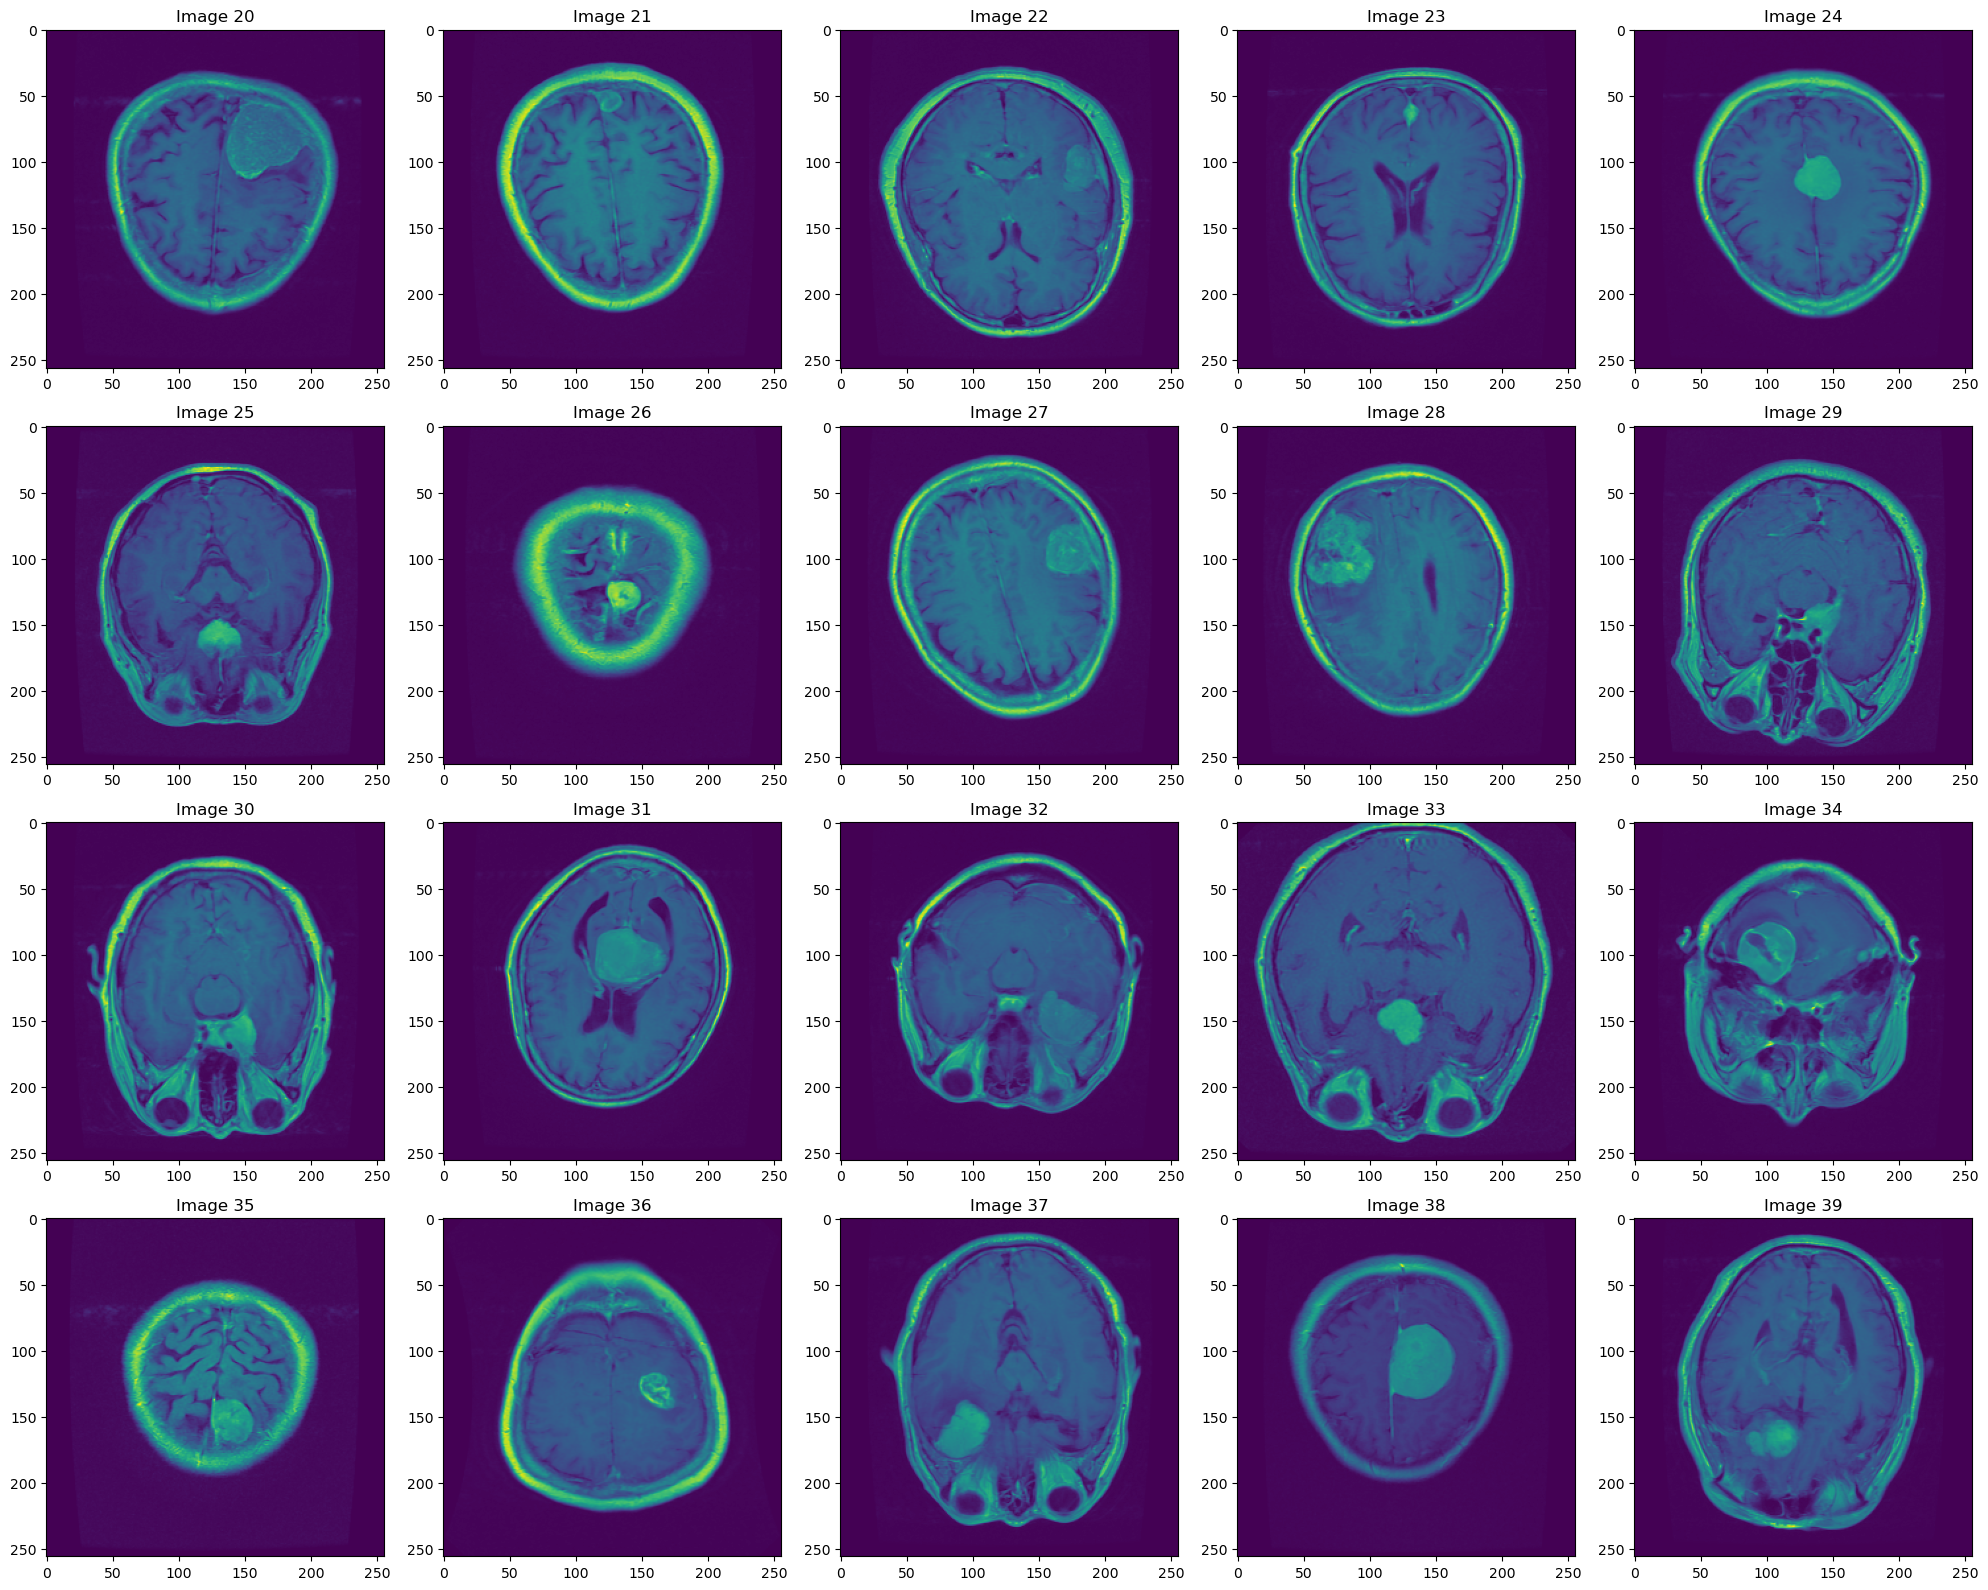

In [15]:
#Visual inspection (Sanity Check) ~ Rotation and Cropping
fig, axs = plt.subplots(4, 5, figsize=(20, 16)) #Create figure with 20 subplots
#Loop over 20 images and display them
for i in range(20):
    index = i+20 #Set image index
    #Calculate row and column indices
    row_index = i // 5
    col_index = i % 5
    #Display newly preprocessed images
    axs[row_index, col_index].imshow(tmr_filt.iloc[index]['img_arr'])
    axs[row_index, col_index].set_title(f"Image {index}")
plt.tight_layout();

In [16]:
#Check labels
print(set(kg_full['label']))
print(set(tmr_filt['label']))

{'yes', 'no'}
{1, 2, 3}


In [17]:
## Alter data for use with Tensorflow ##
# ie. Cannot have categorical labels as shown above, must turn into binary 0/1 or one-hot-encode
kg_full['label'] = kg_full['label'].map({'no': 0, 'yes': 1}) #Change labels in kg_full to binary
tmr_filt['label'] = tmr_filt['label'].map({1: 1, 2: 1, 3: 1}) #Change labels in tmr_full
combined_df = pd.concat([kg_full[['img_arr','label']], tmr_filt[['img_arr','label']]], axis=0, ignore_index=True) #Combine both dataframes into one
#Shuffle the new dataframe
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
#Split the combined dataframe into training and validation sets (70% training, 20% validation, 10% test)
train_df, val_df = train_test_split(combined_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.66, random_state=209)

### Create TensorFlow Dataset

In [18]:
## Joining to create Tensorflow Dataset object ##
def create_tf_dataset(df, img_col, label_col):
    #Extract data
    images = np.stack(df[img_col].values)
    labels = df[label_col].values.astype('int')
    #Create TensorFlow dataset (shuffle data, and prefetch for speed)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(len(images)).prefetch(tf.data.AUTOTUNE)
    return dataset
#Create separate TensorFlow datasets for training, validation, and test
train_dataset = create_tf_dataset(train_df, 'img_arr', 'label')
val_dataset = create_tf_dataset(val_df, 'img_arr', 'label')
test_dataset = create_tf_dataset(test_df, 'img_arr', 'label')

In [19]:
#Evaluate if creation of TF dataset worked:
# Get the first batch of elements from the dataset
batch_size = 1
batch = train_dataset.batch(batch_size).take(20)

# Extract the images, labels, and participant IDs (PID) from the batch
images, labels = next(iter(batch))
print(f'The shape of the tensor in this dataset is: {images.shape}')
# Print the shapes and labels of the images
print(f"Training Image shape: {images.shape}, Label: {labels.numpy()}")

The shape of the tensor in this dataset is: (1, 256, 256, 1)
Training Image shape: (1, 256, 256, 1), Label: [1]


### Comparison of preliminary and final EDA

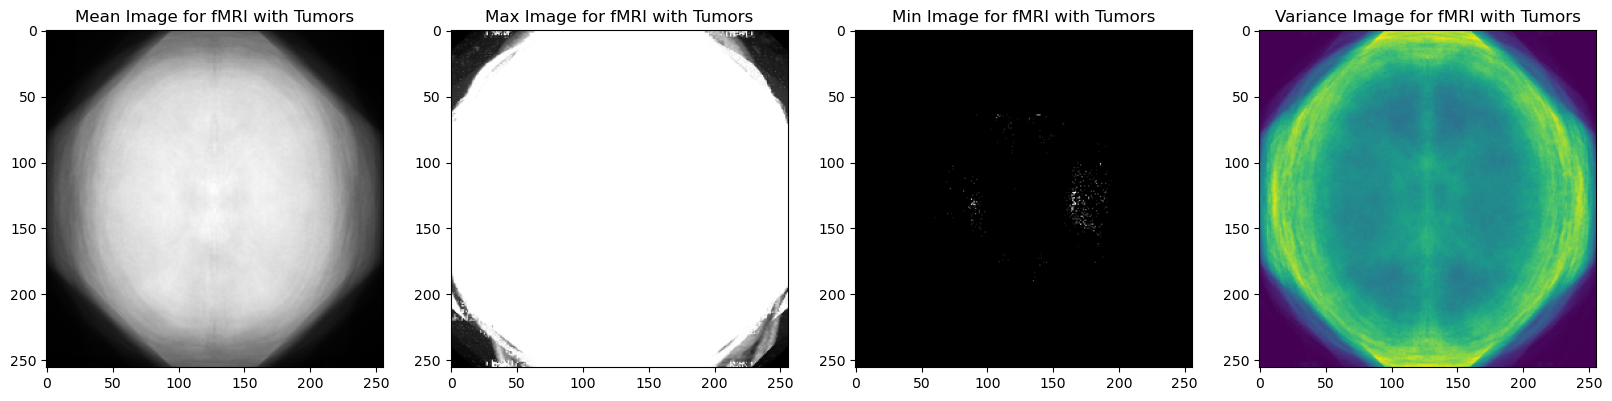

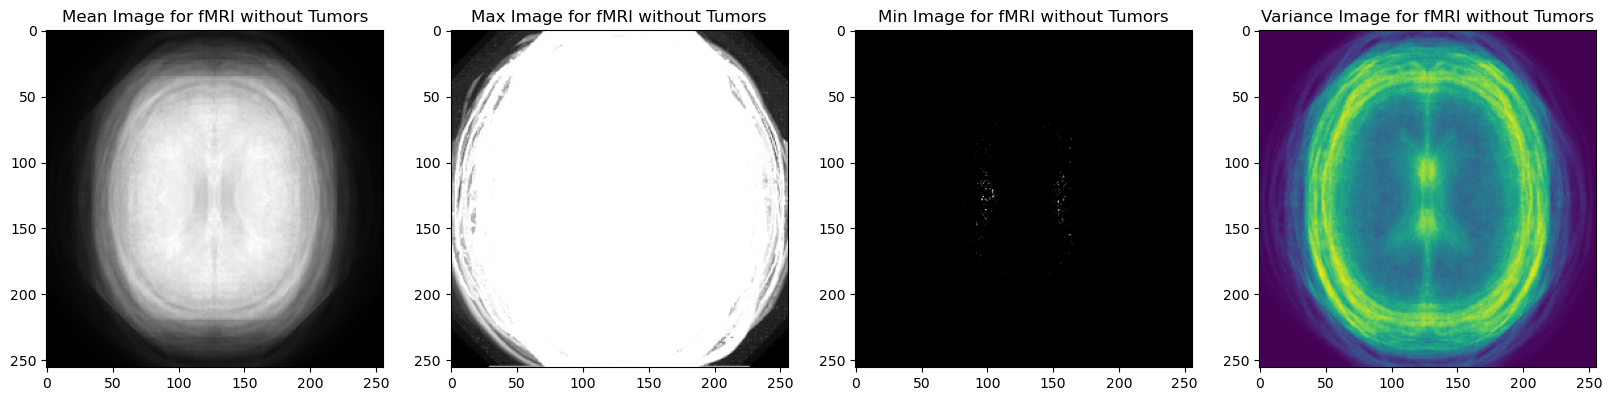

In [20]:
#Define function to evaluate pixel intensities across images within a batch
def compute_image_batch(batch, label):
    images, labels = batch #Pull out required information from batch
    indices = tf.where(labels == label) #Create logical vector indicating brains with/without tumors
    subset = tf.gather(images, indices) #Filter available data depending on presence or absence of tumor
    mean_image = tf.math.reduce_mean(subset, axis=0) #Determine mean pixel intensity values of images within batch
    max_image = tf.math.reduce_max(subset, axis=0) #Determine max pixel intensity values of images within batch
    min_image = tf.math.reduce_min(subset, axis=0) #Determine minimum pixel intensity values of images within batch
    variance_image = tf.math.reduce_variance(subset, axis=0) #Determine variance of intensity values among images within batch
    return mean_image, min_image, max_image, variance_image

#Retrieve batch from training dataset
batch_size = 3000
batch = train_dataset.batch(batch_size)

## fMRI images with tumors ##
#Evaluate pixel intensities across training dataset
mean_image_batch, min_image_batch, max_image_batch, variance_image = compute_image_batch(next(iter(batch)), label=1)

#Plot mean, max, min, and variance of image batches
fig, axes = plt.subplots(1, 4, figsize = (20, 20))
axes[0].imshow(mean_image_batch[0], cmap='gray') #Visualize Mean across batch
axes[0].set_title('Mean Image for fMRI with Tumors')
axes[1].imshow(max_image_batch[0], cmap='gray') #Visualize Max across batch
axes[1].set_title('Max Image for fMRI with Tumors')
axes[2].imshow(min_image_batch[0], cmap='gray') #Visualize Min across batch
axes[2].set_title('Min Image for fMRI with Tumors')
axes[3].imshow(variance_image[0]) #Visualize Variance across batch
axes[3].set_title('Variance Image for fMRI with Tumors')
plt.show();

## fMRI images without tumors ##
#Evaluate pixel intensities across training dataset
mean_image_batch_2, min_image_batch_2, max_image_batch_2, variance_image_2 = compute_image_batch(next(iter(batch)), label=0)

#Plot mean, max, min, and variance of image batches
fig, axes = plt.subplots(1, 4, figsize = (20, 20)) 
axes[0].imshow(mean_image_batch_2[0], cmap='gray') #Visualize Mean across batch
axes[0].set_title('Mean Image for fMRI without Tumors')
axes[1].imshow(max_image_batch_2[0], cmap='gray') #Visualize Max across batch
axes[1].set_title('Max Image for fMRI without Tumors')
axes[2].imshow(min_image_batch_2[0], cmap='gray') #Visualize Min across batch
axes[2].set_title('Min Image for fMRI without Tumors')
axes[3].imshow(variance_image_2[0]) #Visualize Variance across batch
axes[3].set_title('Variance Image for fMRI without Tumors')
plt.show();

It is immediately apparent that after preprocessing images with and without tumors are now far more similar than before. However, in order to evaluate if we resolved all the issues highlighted above we need to compare the concerning images from our preliminary EDA with our new EDA output.

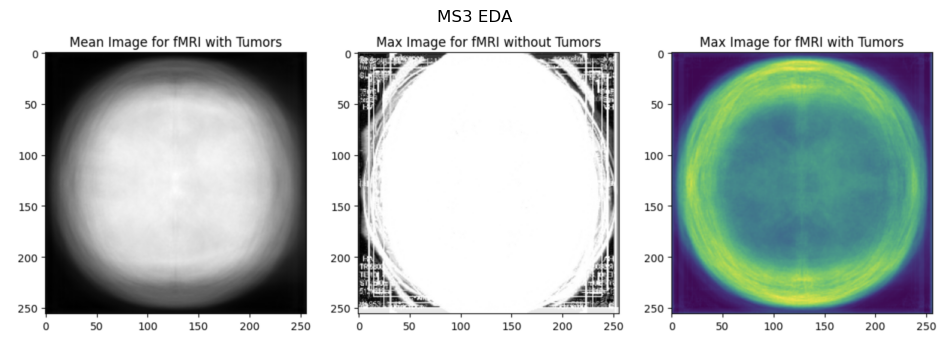

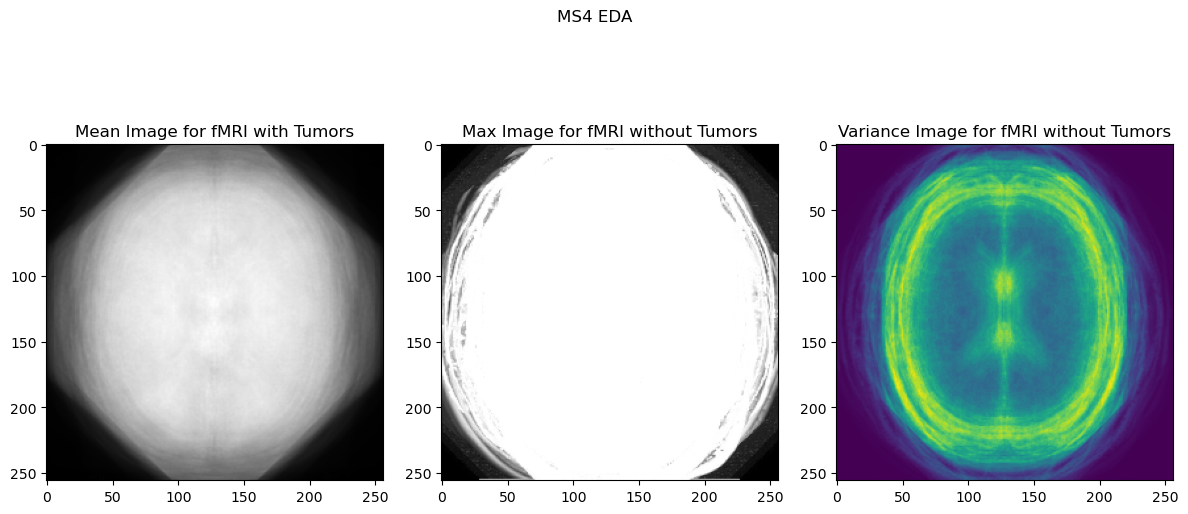

In [21]:
#Comparison of EDA from preliminary EDA with new pre-processing
Comp_img = plt.imread('Closeup.png') #Load image
fig = plt.figure(figsize=(12,6)) #Create new figure
plt.title('MS3 EDA') #Add title to plot
plt.imshow(Comp_img) #Display image on figure
plt.axis('off') #Remove the axes
plt.show();

#Plot New EDA results
fig, axs = plt.subplots(1,3, figsize = (12,6))
axs[0].imshow(mean_image_batch[0], cmap='gray') #Visualize Mean across batch
axs[0].set_title('Mean Image for fMRI with Tumors')
axs[1].imshow(max_image_batch_2[0], cmap='gray') #Visualize Max across batch
axs[1].set_title('Max Image for fMRI without Tumors')
axs[2].imshow(variance_image_2[0]) #Visualize Variance across batch
axs[2].set_title('Variance Image for fMRI without Tumors')
plt.suptitle('MS4 EDA') #Add title to plot
plt.tight_layout();

As this comparison indicates, the new preprocessing procedure is superior as it does not include any artifacts such as the image borders and annotations present in the preliminary EDA. Additionally, because the brain images are now in the same orientation (axial) and direction we now observe some commonly shared anatomical landmarks in the brain such as the corpus callosum (line of connective tissue in the brain which connects seperate brain hemispheres). 

Now, we can visualize our data across both groups to gain a deeper understanding of the image properties of tumors.

### Visualization of fMRI data

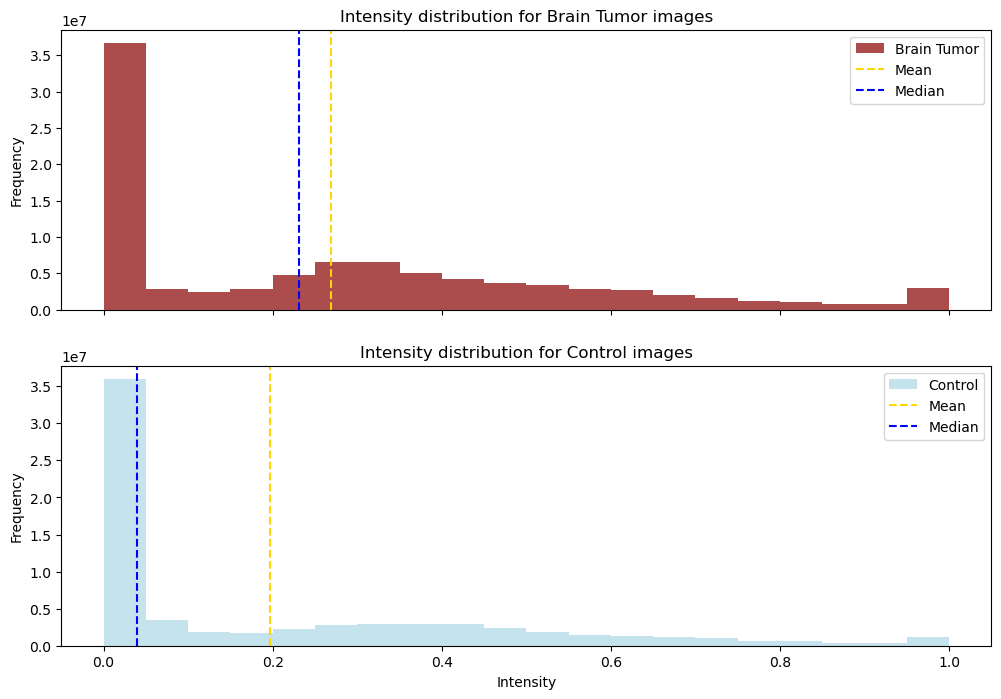

In [22]:
## Plotting the pixel intensities of images with brain tumors ##
#Create figure
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
#Isolate and plot brain data for those with tumors
tumor = train_df[train_df['label'] == 1]
tumor_arr = tumor['img_arr'].dropna().values
intensities = np.array([item for sublist in tumor_arr for item in sublist])
flatten_intensities = intensities.flatten()
axs[0].hist(flatten_intensities, bins=20, alpha=0.7, label='Brain Tumor', color='darkred') #Plot intensity values as histogram
tumor_mean = intensities.mean()
axs[0].axvline(x=tumor_mean, color='gold', linestyle='--', label='Mean') #Plot mean intensity value for images with tumors
tumor_median = np.median(intensities)
axs[0].axvline(x=tumor_median, color='b', linestyle='--', label='Median') #Plot median intensity value for images with tumors
#Prettify
axs[0].set_title('Intensity distribution for Brain Tumor images')
axs[0].set_ylabel('Frequency')
axs[0].legend();

#Isolate and plot brain data for those without tumors
healthy = train_df[train_df['label'] == 0]
healthy_arr = healthy['img_arr'].dropna().values
intensities = np.array([item for sublist in healthy_arr for item in sublist])
flatten_intensities = intensities.flatten()
axs[1].hist(flatten_intensities, bins=20, alpha=0.7, label='Control', color='lightblue') #Plot intensity values as histogram
healthy_mean = intensities.mean()
axs[1].axvline(x=healthy_mean, color='gold', linestyle='--', label='Mean') #Plot mean intensity value for images with tumors
healthy_median = np.median(intensities)
axs[1].axvline(x=healthy_median, color='b', linestyle='--', label='Median') #Plot median intensity value for images with tumors
#Prettify
axs[1].set_title('Intensity distribution for Control images')
axs[1].set_xlabel('Intensity')
axs[1].set_ylabel('Frequency')
axs[1].legend();

What is apparent from this plot is that pixel intensity values (mean and median) are higher in images of brains with tumors, compared to images of brains without tumors. This potentially indicates that tumors present themselves in images as clustered regions of high instensity values -- a valuable insight indeed. Additionally, the mean appears to be higher than the median across each type of image suggesting our image data might be skewed (ie. some images may have higher intensity pixel values -- perhaps associated with the size of a tumor). However, given that both our distributions are skewed, I do not believe these differences are cause for concern.

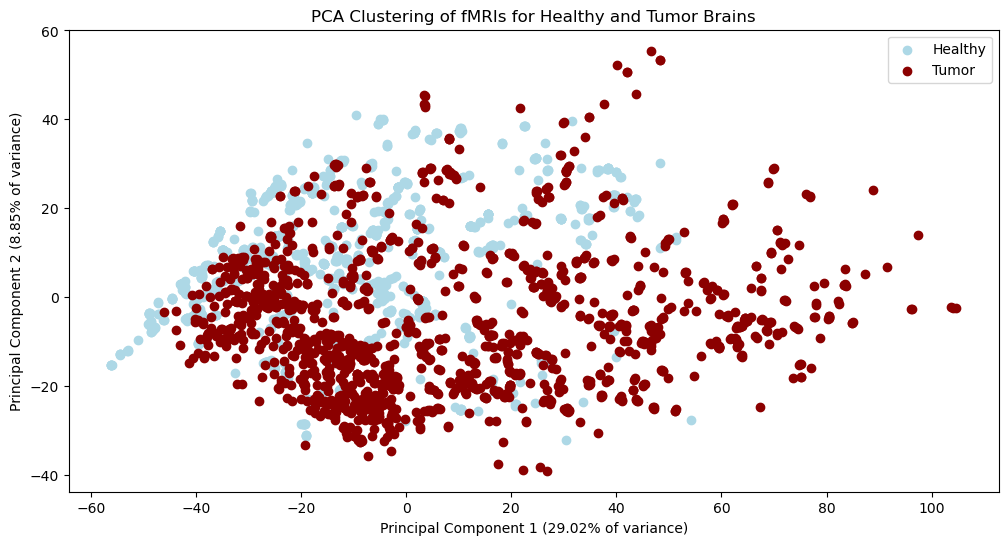

In [23]:
## Plotting the first two Principal Components ##
# These two components are theorized to explain a majority of the variance in the data

#Get rid of NA's (there are none, but good practice)
tumor_arr = train_df['img_arr'].dropna().values
labels = train_df['label'].dropna().values

#Determine the two components which capture most of the variance
image_matrix = np.array([img.flatten() for img in tumor_arr])
pca = PCA(n_components=2)
pca.fit(image_matrix)
transformed = pca.transform(image_matrix)

#Get the variance captured by each principal component
variance = pca.explained_variance_ratio_

#Plot PCA results
colors = ['lightblue', 'darkred']
label_names = ['Healthy', 'Tumor']
fig, ax = plt.subplots(1,1, figsize = (12,6))
for label, color in zip(range(0, 2), colors):
    indices = np.where(np.array(labels) == label)[0]
    ax.scatter(transformed[indices, 0], transformed[indices, 1], c=color, label=f"{label_names[label]}")
ax.legend()
ax.set_xlabel(f"Principal Component 1 ({variance[0]:.2%} of variance)")
ax.set_ylabel(f"Principal Component 2 ({variance[1]:.2%} of variance)")
ax.set_title('PCA Clustering of fMRIs for Healthy and Tumor Brains');


As is indicated by the PCA plot above, the two clusters of data (Brains with & without tumors) are mostly overlapping. There does appear to be differences between the two groups insofar as images of brains without tumors are more variable on PC2. However, Most of the varaince is captured by PC1 (29.11%) and overall a small amount of variance is captured by both principal components (29.11+8.91= 38.02%) -- suggesting a PCA is an ineffective approach to differentiating between our two classes.

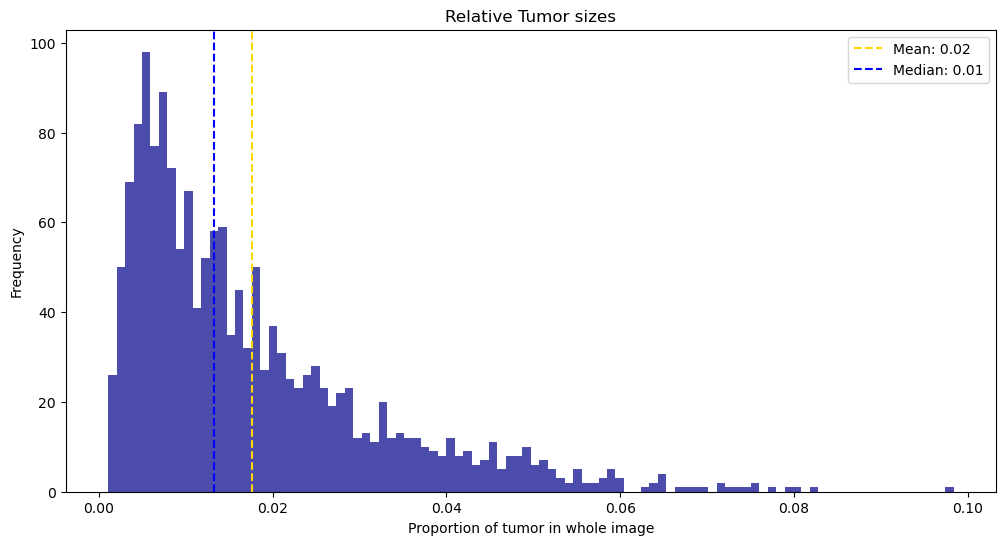

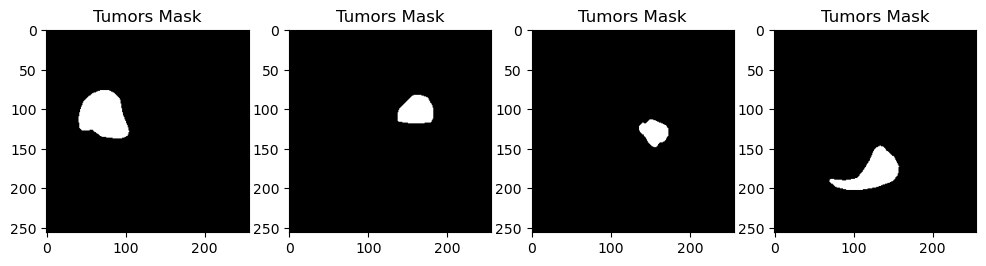

In [24]:
#Create new dataframe for plotting the relative size of tumors and masks 
# Note: This data was removed when creating our tensorflow dataset so I create a different dataset here.
#Separate 'pred' labeled samples --> test set
kg_test = kg_full[kg_full['label'] == 'pred']
kg_full = kg_full[kg_full['label'] != 'pred']

#Change labels in kg_full to binary
kg_full['label'] = kg_full['label'].map({'no': 0, 'yes': 1})

#Change labels in tmr_full
tmr_full['label'] = tmr_full['label'].map({1: 1, 2: 1, 3: 1}) 

#Combine both dataframes into one
combined_df = pd.concat([kg_full, tmr_full], axis=0, ignore_index=True)

#Instantiate LabelEncoder to change PID to numeric integer
pid_encoder = LabelEncoder()

#Convert all 'PID' values to strings to use label encoder
combined_df['PID'] = combined_df['PID'].astype(str)

#Fit encoder on 'PID' and transform to numerical indices
combined_df['PID'] = pid_encoder.fit_transform(combined_df['PID'])

#Shuffle dataframe
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

#Split combined dataframe into training and validation sets (70% training, 20% validation, 10% test)
train_df2, val_df2 = train_test_split(combined_df, test_size=0.3, random_state=42)
val_df2, test_df2 = train_test_split(val_df, test_size=0.66, random_state=209)

#Plot histogram of the relative size of tumors
fig, axs = plt.subplots(1,1, figsize = (12,6))
tumor_masks = train_df2['tum_mask'].dropna()
tumor_masks = [cv2.resize(img, (256,256)) for img in tumor_masks]
area_tumor_masks = [np.sum(img == 1) / (img.shape[0] * img.shape[1]) for img in tumor_masks]
n, bins, patches = plt.hist(area_tumor_masks, bins=100, alpha=0.7, color='darkblue')
plt.xlabel('Proportion of tumor in whole image')
plt.ylabel('Frequency')
plt.title('Relative Tumor sizes')
#Calculate and add mean and median tumor sizes
mean_tum = np.mean(area_tumor_masks)
median_tum = np.median(area_tumor_masks)
plt.axvline(mean_tum, color='gold', linestyle='--', label=f"Mean: {mean_tum:.2f}")
plt.axvline(median_tum, color='blue', linestyle='--', label=f"Median: {median_tum:.2f}")
plt.legend()
plt.show();

#Plot masks of tumors to visualize tumor sizes
fig, axs = plt.subplots(1,4, figsize = (12,6))
tumor_masks = train_df2['tum_mask'].dropna()
tumor_masks = [cv2.resize(img, (256,256)) for img in tumor_masks]
for i, mask in enumerate(tumor_masks):
  axs[i].imshow(mask, cmap = 'gray')
  axs[i].set_title('Tumors Mask')
  if i == 3:
    break

From the histogram above it appears that most tumors emcompass between 1-2% of the whole photo with a mean proportion of 2% and a median proportion of 1%. This is also evident from the plotted masked tumor outlines below the histogram. Therefore, the tumors emcompass a small minority of the brain images -- a statistic which emphasizes the difficulty of diagnosing brain tumors and highlights the potential of machine learning methods for classifying brain tumors. From a practical perspective, the 1-2% benchmark also suggests that I should aim to tune my CNN to have a receptive field of at least 1-2% of the image space -- between 26 & 52 pixels.

One final insight gleaned from the second round of EDA was that our image set was actually incompatible with the kinds of analyses we originally intended to do. Specifically, we initially chose the 'FIGSHARE' dataset as we were interested in using multiple scans from the same individual to see whether representing these within-subject repeated observations as channels would improve classification. Our rationalization was that if the repeated images were taken at different depths within the individual, then this might enable our network to improve classification by recognizing tumors at multiple depths. In a similar vein, we also had planned on representing these repeated observations within a RNN+CNN architecture to see if this would improve classification. However, both of these goals are ultimately impossible with our current data as our EDA showed the repeated observations in our dataset were due to different planar orientations of the brain (ie. axial, saggital, coronal); what we actually required for our original idea is multiple images from the same individual, within the same planar orientation, at different depths. Instead, we will implement several CNN architectures and compare their performance to eachother before selecting the best model and creating an ensemble of predictions using the best model with two pretrained models for transfer learning.

## Convolutional Neural Networks
### Model Attempt #1: Standard (Vanilla)

This simple convolutional network is composed of the four prototypical features of a convolutional network: convolutional layers, pooling layers, activation functions, and fully connected layers. 

In this and all other models we train we leverage an early stopping condition with a patience of five, a learning rate plateau decay rate scheduler, adam with weight decay, a model checkpoint to save the best fitting model, and a custom lambda layer to perform data augmentation.

In [25]:
#Common model fitting settings:
# 1) Adding an early stopping callback with patience = 5
early_5 = EarlyStopping(monitor='val_loss', patience=5,mode='min')
# 2) Defining a learning rate (plateau) scheduler
plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.0001)
# 3) Swapping out Adam optimizer for AdamW optimizer to improve the performance of generalization
wadam = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
# 4) Crafting a Data Augmentation Pipeline
def augment_images(inputs):
    # Apply horizontal flip
    x = tf.image.random_flip_left_right(inputs)
    # Apply rotation
    x = tfa.image.rotate(x, tf.constant(9 * (3.14159 / 180)))
    # Resize back to original dimensions
    x = tf.image.resize(x, [256, 256])
    return x
# 5) Add ModelCheckpoint callback to save the best model
BestFit = ModelCheckpoint(filepath='van_fit.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

In [26]:
### Vanilla Convolutional Network ###
input_layer = Input(shape=(256, 256, 1))
augmented = Lambda(augment_images)(input_layer)
x = Conv2D(32, (7, 7), strides=(2, 2), activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(augmented)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
van_model = Model(inputs=input_layer, outputs=predictions, name="Vanilla_27")
van_model.compile(optimizer=wadam, loss='binary_crossentropy', metrics=['accuracy'])
van_model.summary()

Model: "Vanilla_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 125, 125, 32)      1600      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        1

In [27]:
#Reshape images and associated labels to shape required by the model
def reshape_image(image, label):
    reshaped_image = tf.reshape(image, (256, 256, 1))
    reshaped_label = tf.reshape(label, (1,1))
    return reshaped_image, reshaped_label

#Optimize loading of data
train_dataset = train_dataset.map(reshape_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(reshape_image, num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
#Load saved model (if it exists)
model_file = 'van_fit.h5'
if os.path.exists(model_file):
    print("Loading existing model") #Feedback
    van_model = load_model(model_file)
    #Load training history from associated JSON file
    with open('vanilla_history.json', 'r') as f:
        van_history = json.load(f)
else:
    print("Training new model") #Feedback
    #Fit ~ Vanilla Model (if it doesn't exist)
    vanilla_history = van_model.fit(train_dataset.batch(32), epochs=15, validation_data=val_dataset.batch(32), callbacks=[early_5, plateau_lr, BestFit])
    #Convert history to a dictionary (to save)
    van_history = vanilla_history.history
    #Save history to JSON file
    with open('vanilla_history.json', 'w') as f:
        json.dump(van_history, f, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)
        #Line above necessary to fix issue with python float32 values.
    #Save trained model
    van_model.save(model_file)
#Load Keras model
model = load_model('van_fit.h5')
#Calculate # of trainable and non-trainable parameters
trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in model.trainable_weights)
non_trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in model.non_trainable_weights)

Loading existing model


The total number of trainable parameters is 59490369 and 2752 Non-trainable parameters.


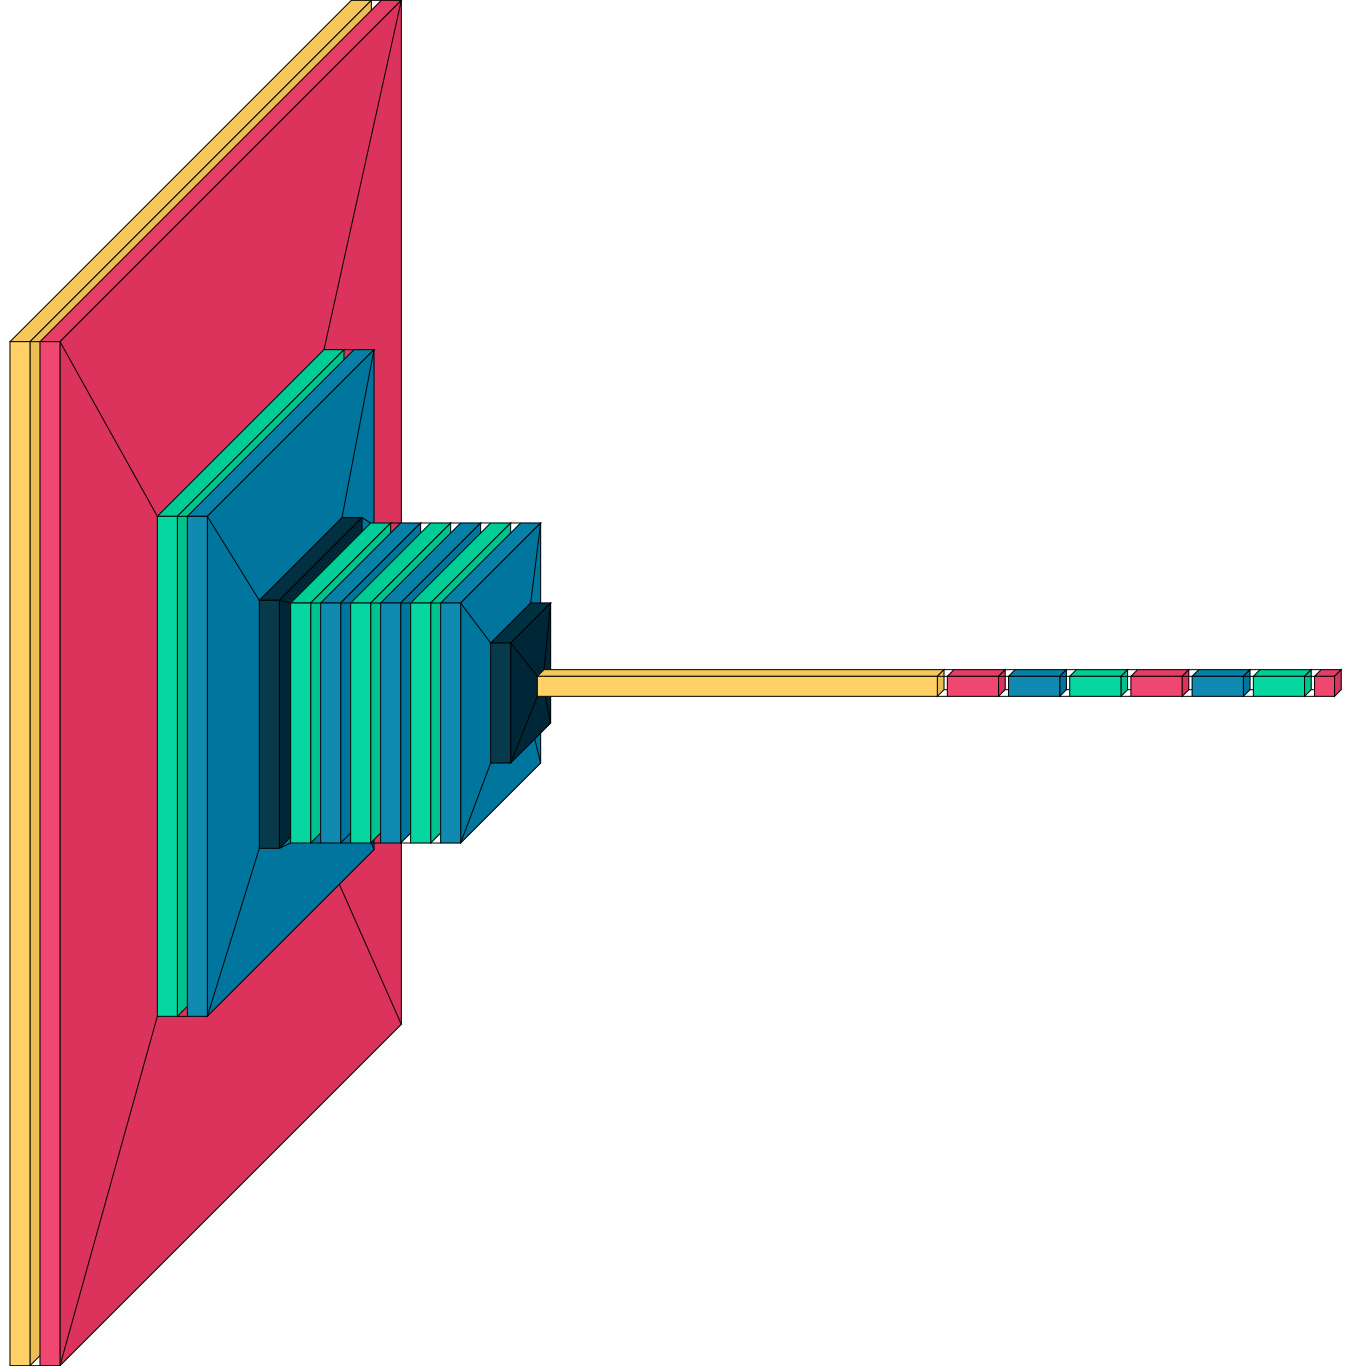

In [29]:
#Print parameters counts
print(f'The total number of trainable parameters is {trainable_params} and {non_trainable_params} Non-trainable parameters.')
#Visualize Model Architecture
visualkeras.layered_view(model, to_file='van_view.png')
#Visualze Model Hierarchy
#plot_model(model)

In [30]:
#Apply the same preprocessing steps to test as validation and training data
test_dataset = test_dataset.map(reshape_image, num_parallel_calls=tf.data.AUTOTUNE)
#Batch test data
test_dataset = test_dataset.batch(32)

#Evaluate model on test data
van_test_loss, van_test_accuracy = van_model.evaluate(test_dataset)
print(f"Test loss: {van_test_loss:.4f}, Test accuracy: {van_test_accuracy:.4f}")

23/23 [==============================] - 3s 22ms/step - loss: 0.0656 - accuracy: 0.9845
Test loss: 0.0656, Test accuracy: 0.9845


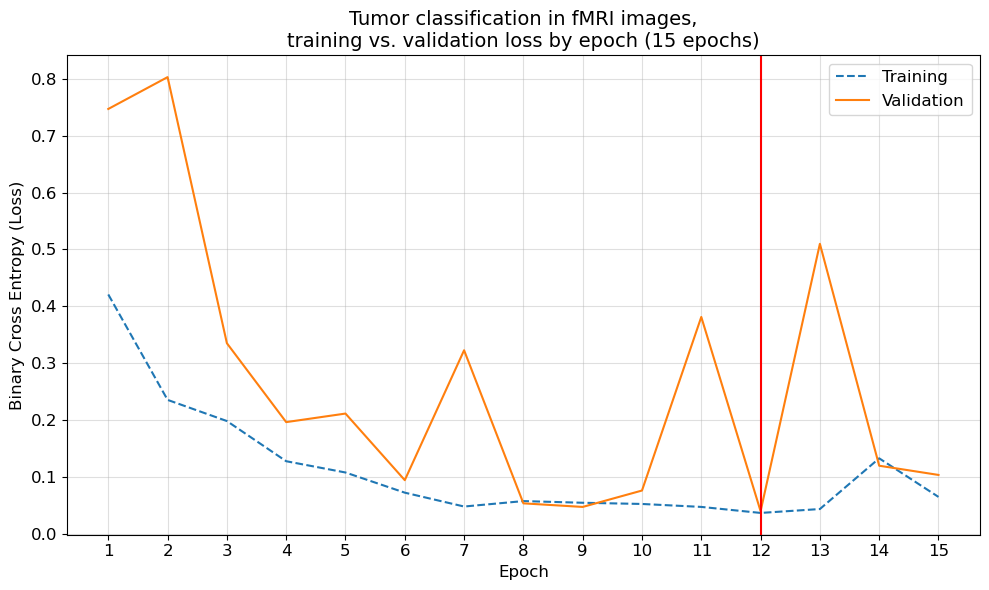

In [31]:
#Plot training and validation loss for vanilla model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(van_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images,\ntraining vs. validation "
    "loss by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    van_history["loss"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    van_history["val_loss"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Binary Cross Entropy (Loss)", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(van_history['val_loss'])+1, c ='red', label="Callback model", color='r')      
plt.tight_layout()

Validation loss gradually decreases until epoch 6 where it becomes unstable and plateaus. There is little improvement in learning after epoch 6, but there is increased instability which suggests there may be an issue with the model architecture or the optimizer used. Red line indicates the best fitting model which is saved and reloaded.

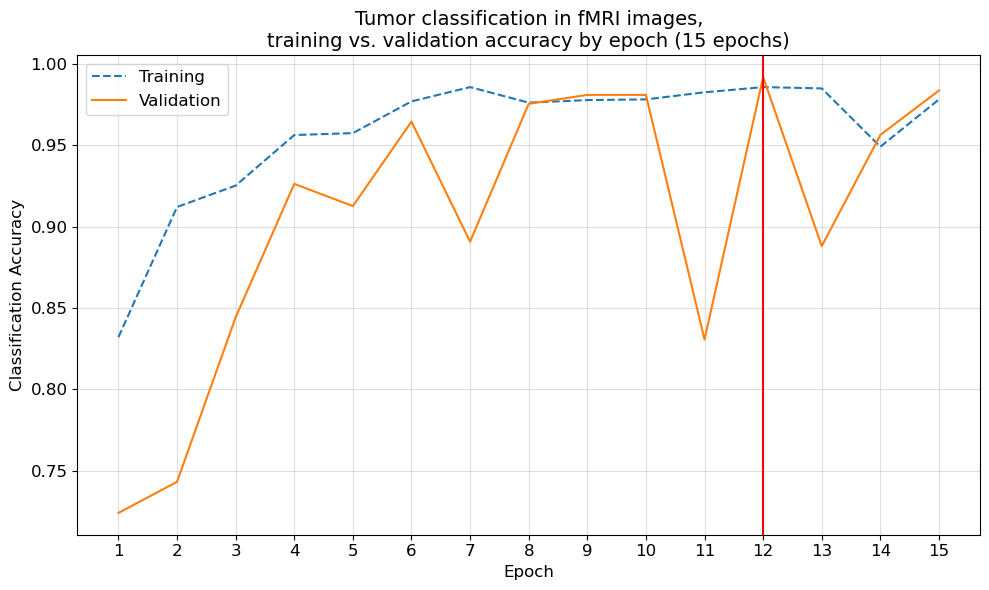

In [32]:
#Plot training and validation accuracy for vanilla model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(van_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images,\ntraining vs. validation "
    "accuracy by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    van_history["accuracy"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    van_history["val_accuracy"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Classification Accuracy", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(van_history['val_loss'])+1, c ='red', label="Callback model", color='r')  
plt.tight_layout()

Accuracy across the validation and training sets gradually improves until epoch 8 where similar to loss it becomes unstable. The red line indicates the best fitting model which is saved and reloaded.

### Model Attempt #2: Standard + Google Brain (Strawberry) (Dilated/Transposed convolutions)
NOTE: This model reduces some image artifacts by using transposed convolutions in lieu of normal convolutions, and average pooling in lieu of maxpooling as suggested by Google Brain (Odena et al., 2016).

In [33]:
### Strawberry Convolutional Neural Network ###
input_layer = Input(shape=(256, 256, 1))
augmented = Lambda(augment_images)(input_layer)
x = Conv2D(2, (3, 3), strides=(1, 1), dilation_rate=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(augmented)
x = BatchNormalization()(x)
x = Conv2D(4, (3, 3), strides=(1, 1), dilation_rate=(2, 2), activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Conv2D(4, (3, 3), strides=(1, 1), dilation_rate=(4, 4), activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(4, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = Conv2DTranspose(2, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = AveragePooling2D(pool_size=(2, 2))(x)  # Add a pooling layer before flattening
x = Flatten()(x)
x = Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(8, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
dilation_model = Model(inputs=input_layer, outputs=predictions, name="DIL_25")
dilation_model.compile(optimizer=wadam, loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
#Early stopping callback with patience = 5
DIL_early_5 = EarlyStopping(monitor='val_loss', patience=5,mode='min')
#Learning rate (plateau) scheduler
DIL_plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.0001)
#ModelCheckpoint callback to save the best model
DIL_BestFit = ModelCheckpoint(filepath='DIL_best_fit.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

#Load model (if it exists)
model_file = 'DIL_best_fit.h5'
if os.path.exists(model_file):
    print("Loading existing model")
    dilation_model = load_model(model_file)
    #Load training history via JSON file
    with open('straw_history.json', 'r') as f:
        straw_history = json.load(f)
else:
    print("Training new model")
    #Fit model (if it doesn't exist)
    strawberry_history = dilation_model.fit(train_dataset.batch(32), epochs=15, validation_data=val_dataset.batch(32), callbacks=[DIL_early_5, DIL_plateau_lr, DIL_BestFit])
    #Convert history to a dictionary
    straw_history = strawberry_history.history
    #Save history to a JSON file
    with open('straw_history.json', 'w') as f:
        json.dump(straw_history, f, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)
        #Line above necessary to fix issue with python float32 values.    
    #Save trained model
    dilation_model.save(model_file)
dilation_model.summary()

Loading existing model
Model: "DIL_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 256, 256, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 2)       20        
                                                                 
 batch_normalization_6 (Batc  (None, 254, 254, 2)      8         
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 250, 250, 4)       76        
                                                                 
 batch_normalization_7 (Batc  (None, 250, 250, 4)      16        
 hNormalization)                     

The total number of trainable parameters is 7496887 and 68 Non-trainable parameters.


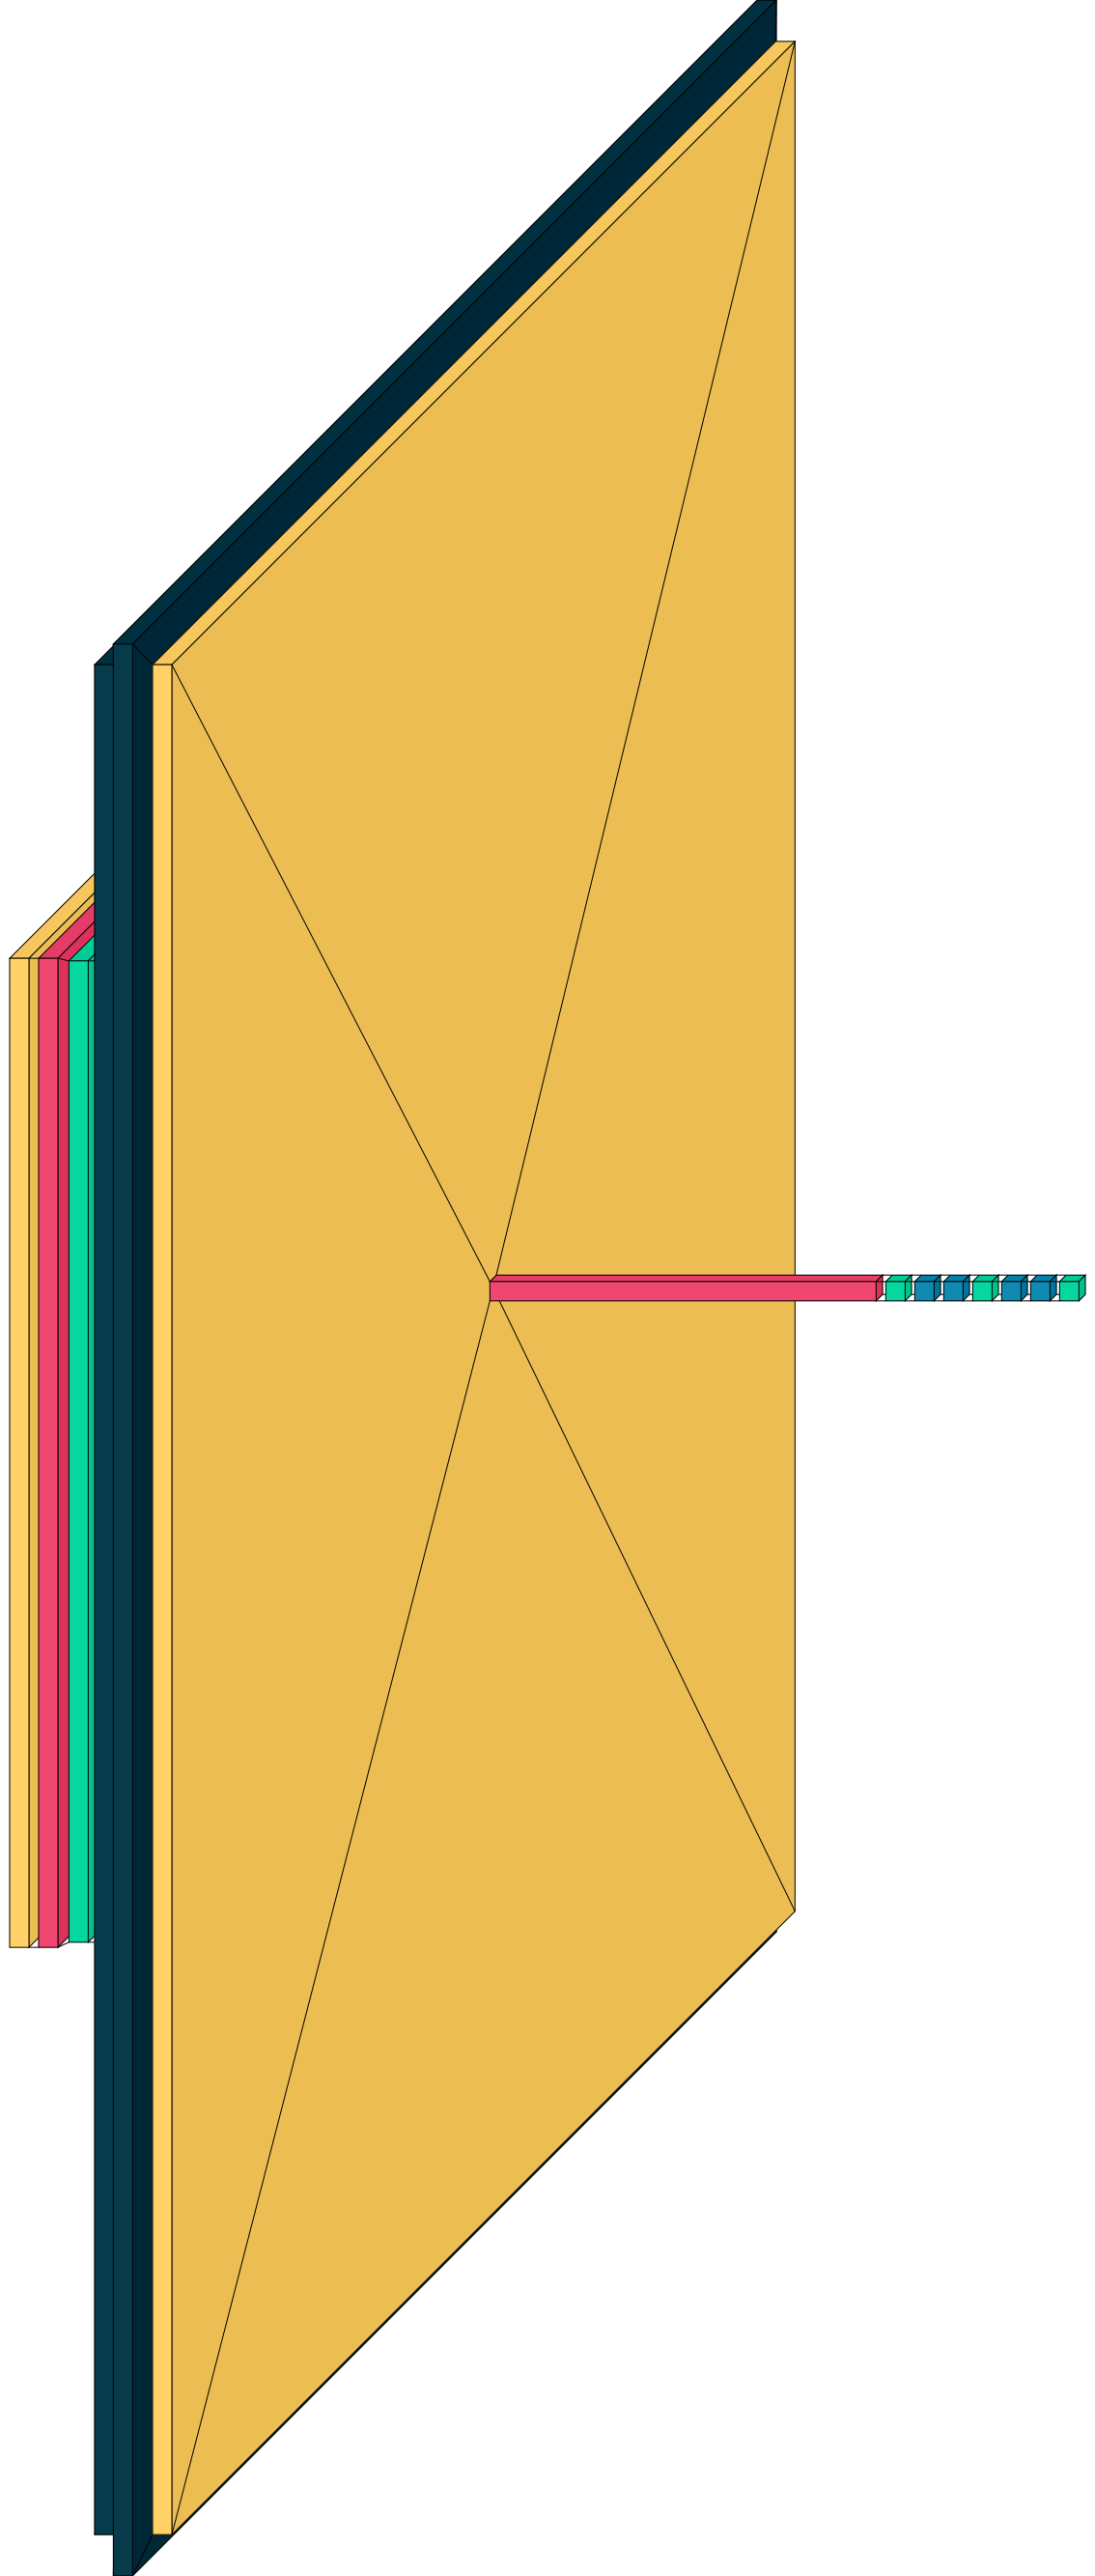

In [35]:
#Load model for visualization
model = load_model('DIL_best_fit.h5')

#Calculate # of trainable and non-trainable parameters
trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in model.trainable_weights)
non_trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in model.non_trainable_weights)
#Report parameter counts
print(f'The total number of trainable parameters is {trainable_params} and {non_trainable_params} Non-trainable parameters.')

#Visualize model architecture
visualkeras.layered_view(model, to_file='Straw_view.png')
#Visualze Model Hierarchy
#plot_model(model)

In [36]:
#Evaluate model on test data
DIL_test_loss, DIL_test_accuracy = dilation_model.evaluate(test_dataset)
print(f"Test loss: {DIL_test_loss:.4f}, Test accuracy: {DIL_test_accuracy:.4f}")

23/23 [==============================] - 2s 52ms/step - loss: 0.0410 - accuracy: 0.9887
Test loss: 0.0410, Test accuracy: 0.9887


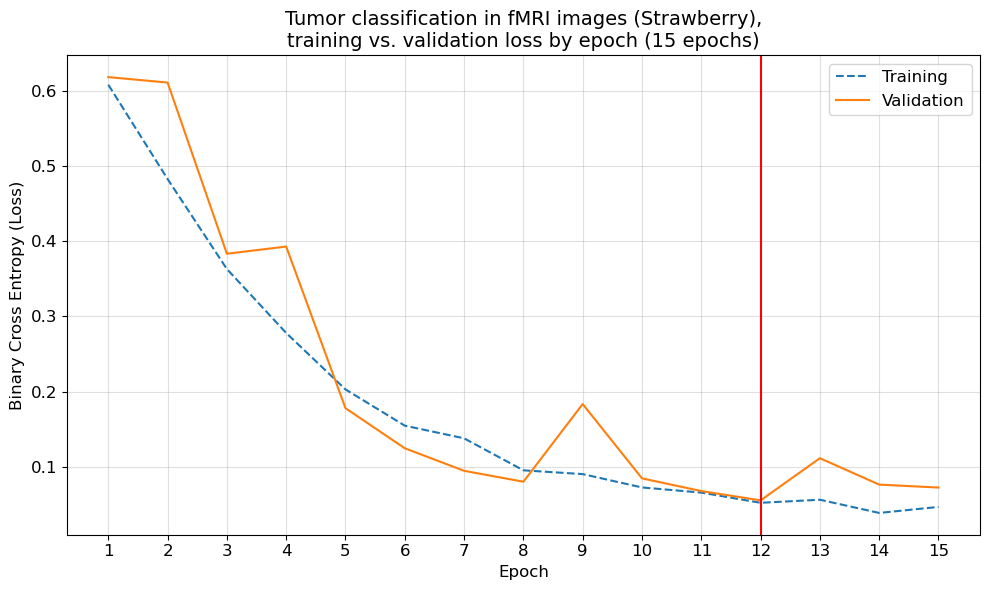

In [37]:
#Plot Training and Validation Loss for model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(straw_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (Strawberry),\ntraining vs. validation "
    "loss by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    straw_history["loss"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    straw_history["val_loss"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Binary Cross Entropy (Loss)", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(straw_history['val_loss'])+1, c ='red', label="Callback model", color='r')       
plt.tight_layout()

Validation loss gradually decreases until epoch 12. Moreover, training and validation accuracy diverges after epoch 12 which implies the existence of overfitting. Overall, training appears smoother for this model than the previous vanilla model. The red line indicates the best fitting model which is saved and reloaded.

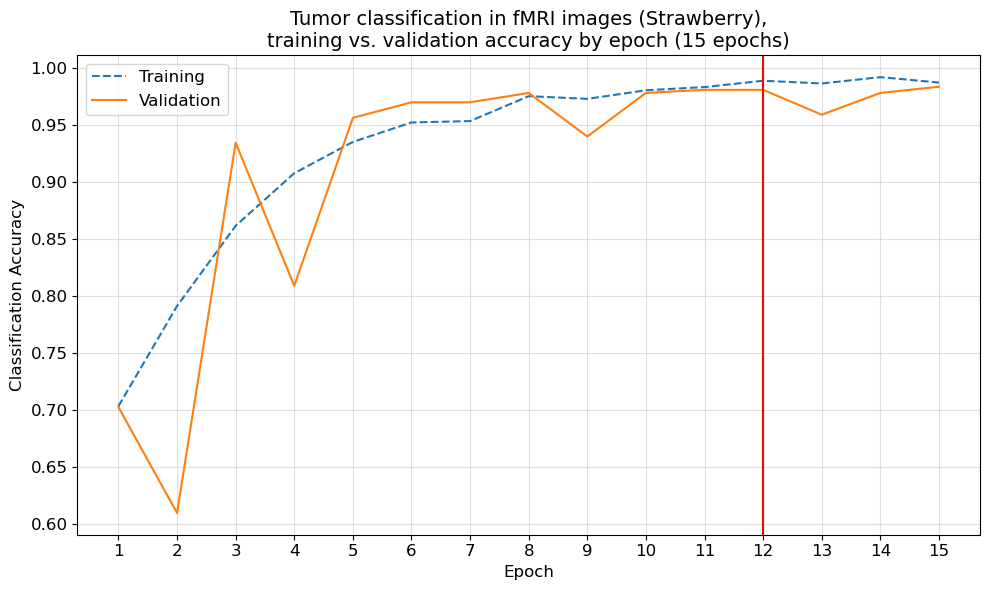

In [38]:
#Plotting training and validation accuracy for the model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(straw_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (Strawberry),\ntraining vs. validation "
    "accuracy by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    straw_history["accuracy"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    straw_history["val_accuracy"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Classification Accuracy", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(straw_history['val_loss'])+1, c ='red', label="Callback model", color='r') 
plt.tight_layout()

Validation accuracy gradually increases until epoch 12. Moreover, similar to the loss, accuracy diverges after epoch 12 which implies the estistence of overfitting. Training appears smoother for this model than the previous vanilla model. The red line indicates the best fitting model which is saved and reloaded.

### Model Attempt #3: Auto-encoder + Google Brain (Chocolate)
This CNN architecture is composed of a decoder+encoder architecture which optimizes the reduction of convolutional artifacts by adding average pooling layers with larger strides -- reducing overlap between pooling regions -- as well as making convolutions equally divisible to minimize potential checkerboard artifacts (Odena et al., 2016).

In [39]:
### Chocolate Convolutional Neural Network ###
input_layer = Input(shape=(256, 256, 1))
augmented = Lambda(augment_images)(input_layer)

#Encoding Layers
x = Conv2D(16, (3, 3), strides=(1, 1), dilation_rate=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(augmented)
x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), strides=(1, 1), dilation_rate=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), strides=(1, 1), dilation_rate=(4, 4), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)

#Decoding Layers
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = Conv2DTranspose(8, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)

#Flattening and Dense Layers
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

#Model Preparation
transposed_model = Model(inputs=input_layer, outputs=predictions, name='Choco_25_CNN')
#Model compilation
transposed_model.compile(optimizer=wadam, loss='binary_crossentropy', metrics=['accuracy'])
transposed_model.summary()

Model: "Choco_25_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 lambda_2 (Lambda)           (None, 256, 256, 1)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 average_pooling2d_1 (Averag  (None, 128, 128, 16)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 average_pooling2d_2 (Averag  (None, 64, 64, 32)       0         
 ePooling2D)                                          

In [40]:
#Early stopping callback with patience = 5
Cho_early_5 = EarlyStopping(monitor='val_loss', patience=5,mode='min')
#Learning rate (plateau) scheduler
Cho_plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.0001)
#ModelCheckpoint callback to save the best model
Cho_BestFit = ModelCheckpoint(filepath='Trans_best_fit.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

#Load model (if it exists)
model_file = 'Trans_best_fit.h5'
if os.path.exists(model_file):
    print("Loading existing model")
    transposed_model = load_model(model_file)
    # Load the training history from the JSON file
    with open('choco_history.json', 'r') as f:
        chocolate_history = json.load(f)
else:
    print("Training new model")
    #Fit ~ Dilated Model (if it doesn't exist)
    choco_history = transposed_model.fit(train_dataset.batch(32), epochs=10, validation_data=val_dataset.batch(32), callbacks=[Cho_early_5, Cho_plateau_lr, Cho_BestFit])
    #Convert history to a dictionary
    chocolate_history = choco_history.history
    #Save history as JSON file
    with open('choco_history.json', 'w') as f:
        json.dump(chocolate_history, f, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)
        #Line above necessary to fix issue with python float32 values.    
    # Save trained model
    transposed_model.save(model_file)

Loading existing model


The total number of trainable parameters is 33604345 and 192 Non-trainable parameters.


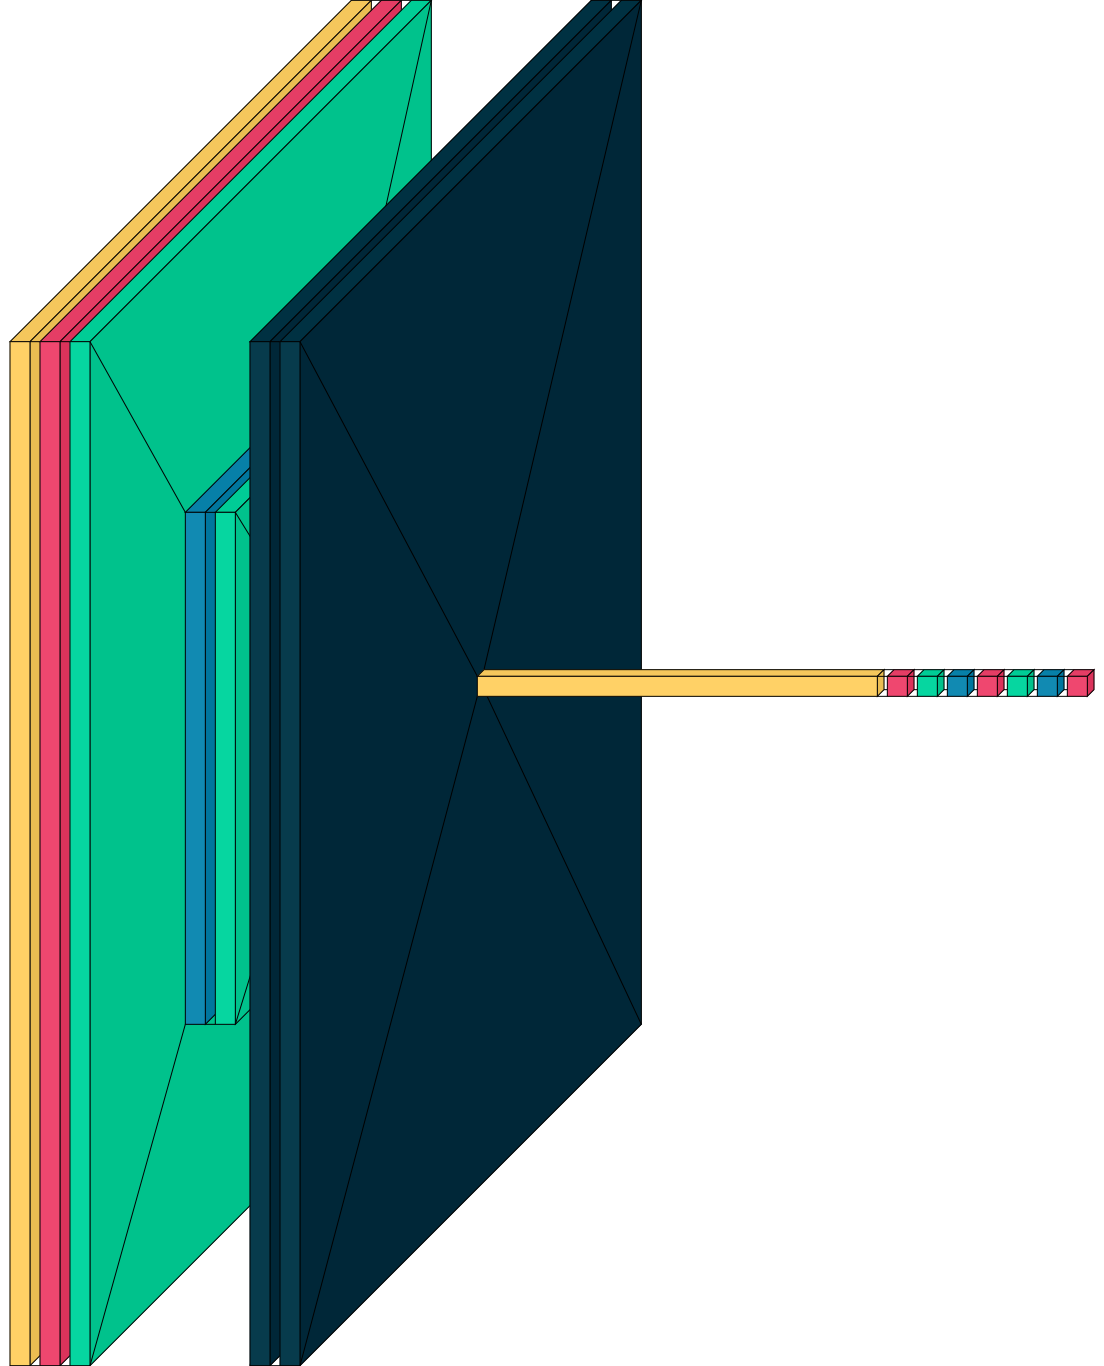

In [41]:
#Load model
model = load_model('Trans_best_fit.h5')

#Calculate trainable and non-trainable parameters
trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in model.trainable_weights)
non_trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in model.non_trainable_weights)

#Report number of trainable and non-trainable parameters
print(f'The total number of trainable parameters is {trainable_params} and {non_trainable_params} Non-trainable parameters.')

#Visualize model architecture
visualkeras.layered_view(model, to_file='Choco_view.png')
#Visualize model hierarchy
#plot_model(model)

In [42]:
# Evaluate the model on the test dataset
trn_test_loss, trn_test_accuracy = transposed_model.evaluate(test_dataset)
print(f"Test loss: {trn_test_loss:.4f}, Test accuracy: {trn_test_accuracy:.4f}")

23/23 [==============================] - 2s 53ms/step - loss: 0.0268 - accuracy: 0.9916
Test loss: 0.0268, Test accuracy: 0.9916


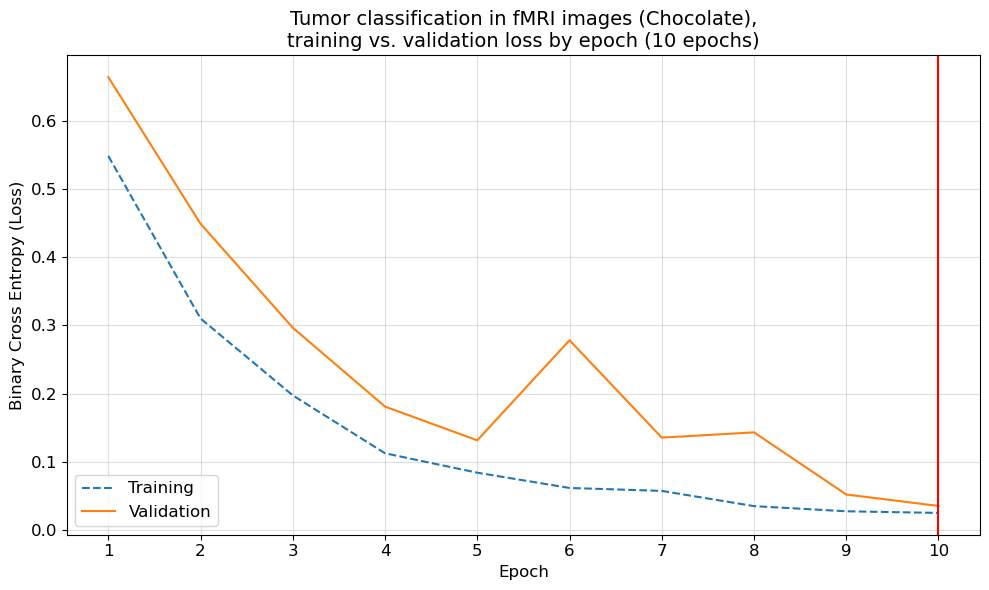

In [43]:
#Visualize training and validation loss for model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(chocolate_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (Chocolate),\ntraining vs. validation "
    "loss by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    chocolate_history["loss"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    chocolate_history["val_loss"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Binary Cross Entropy (Loss)", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(chocolate_history['val_loss'])+1, c ='red', label="Callback model", color='r') 
    
plt.tight_layout()

Learning across both validation and training data was smoother than previous models, and also progressed more quickly and converged better. The red line indicates the best fitting model which is saved and reloaded.

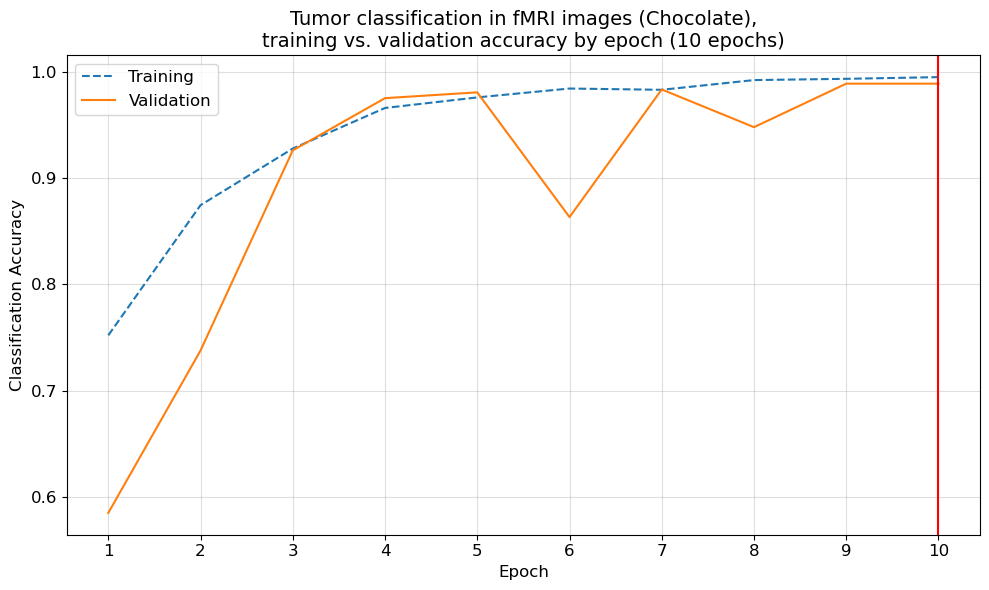

In [44]:
#Visualize training and validation accuracy for model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(chocolate_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (Chocolate),\ntraining vs. validation "
    "accuracy by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    chocolate_history["accuracy"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    chocolate_history["val_accuracy"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Classification Accuracy", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(chocolate_history['val_loss'])+1, c ='red', label="Callback model", color='r')     
plt.tight_layout()

Unlike the loss function, accuracy across the training and validation data show little improvements after the 5th epoch of training. Nevertheless, the training and validation data converge well at the end of training. The red line indicates the best fitting model which is saved and reloaded.

#### Takeaway:
The large vanilla model with 59.5 million parameters had the worst loss (0.07) and test accuracy (98.5). The small strawberry model with 7.5 million parameters had the second best test accuracy (0.04) and loss (98.9). Finally, the medium chocolate model with 33.6 million parameters had the best test loss (0.03), and accuracy (99.2). Beyond considering the performance of the model and number of parameters, plotting the training history revealed that learning between the training and validation test sets converged best and training was smoothest in the chocolate (autoencoder) model -- therefore I will continue with this model.

## Transfer Learning
Next, we compare the performance of the best fitting model to that of previous state-of-the-art models (SoTA) -- VGG16 and GoogLeNet (Inception-V3). However, in order to facilitate comparisons between my model and these SoTA models I will alter the output tensor before the flatten layer across these three models to have the same dimensions  (16x16x16) -- in doing so I will ensure the number of parameters trained in the shared dense+flatten layers across these models are the same.

In [54]:
#Define custom layer to convert grayscale images (1 channel) to RGB (3)
# Note: This layer is necessary because the weights that VGG-16 and GoogLeNet have from training on imagenet were obtained with RGB images
class GrayscaleToRGBLayer(Layer):
    def __init__(self, **kwargs):
        super(GrayscaleToRGBLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.image.grayscale_to_rgb(inputs)

### Best Fitting Model
Note: The dimensions of this model have been altered in order to ensure that the final tensor before the flatten layer has the same dimensionality as the other two models (16x16x16), but the general architecture (encoder + decoder) remains the same. Given that this change in dimensionality may have unintended consequences we will again evaluate loss and accuracy to confirm this model is still preferred.

In [55]:
### Best fitting Auto-encoder architecture ###
#Define best fitting model architecture
input_layer = Input(shape=(256, 256, 1), name='best_input')
augmented = Lambda(augment_images)(input_layer)
#Add the custom GrayscaleToRGB layer (for comparability to pretrained models)
rgb_layer = GrayscaleToRGBLayer()(augmented)

#Encoding Layers
x = Conv2D(16, (3, 3), activation='relu', padding='same')(rgb_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

#Decoding Layers
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), strides = (4,4), activation='relu', padding='same')(x)

#Flatten and Dense Layers
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

#Define Model
best_model = Model(inputs=input_layer, outputs=predictions, name='Best_25_CNN')
#Define AdamW optimizer
wadam = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
#Compile Model
best_model.compile(optimizer=wadam, loss='binary_crossentropy', metrics=['accuracy'])
best_model.summary()

Model: "Best_25_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 best_input (InputLayer)     [(None, 256, 256, 1)]     0         
                                                                 
 lambda_4 (Lambda)           (None, 256, 256, 1)       0         
                                                                 
 grayscale_to_rgb_layer_1 (G  (None, 256, 256, 3)      0         
 rayscaleToRGBLayer)                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      

In [56]:
#Early stopping callback with patience = 5
Best_early_5 = EarlyStopping(monitor='val_loss', patience=5,mode='min')
#Learning rate (plateau) scheduler
Best_plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.0001)
#ModelCheckpoint callback to save the best model
Best_BestFit = ModelCheckpoint(filepath='Best_fit.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

#Load model (if it exists)
model_file = 'Best_fit.h5'
if os.path.exists(model_file):
    print("Loading existing model")
    transposed_model = load_model(model_file)
    #Load training history from JSON file
    with open('opt_history.json', 'r') as f:
        opt_history = json.load(f)
else:
    print("Training new model")
    #Fit ~ Best Model (if it doesn't exist)
    opt_history = best_model.fit(train_dataset.batch(32), epochs=20, validation_data=val_dataset.batch(32), callbacks=[Best_early_5, Best_plateau_lr, Best_BestFit])
    #Convert history to a dictionary
    optimized_history = opt_history.history
    #Save the history to a JSON file
    with open('opt_history.json', 'w') as f:
        json.dump(optimized_history, f, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)
        #Line above necessary to fix issue with python float32 values.    
    #Save the trained model
    best_model.save(model_file)

Training new model
Epoch 1/20
79/79 [==============================] - 5s 43ms/step - loss: 0.5536 - accuracy: 0.7269 - val_loss: 0.5923 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 2/20
79/79 [==============================] - 3s 38ms/step - loss: 0.4354 - accuracy: 0.8077 - val_loss: 0.5576 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 3/20
79/79 [==============================] - 3s 38ms/step - loss: 0.3112 - accuracy: 0.8690 - val_loss: 0.4752 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 4/20
79/79 [==============================] - 3s 38ms/step - loss: 0.2457 - accuracy: 0.9009 - val_loss: 0.2375 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 5/20
79/79 [==============================] - 3s 36ms/step - loss: 0.2124 - accuracy: 0.9180 - val_loss: 0.2555 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 6/20
79/79 [==============================] - 3s 38ms/step - loss: 0.1807 - accuracy: 0.9343 - val_loss: 0.2236 - val_accuracy: 0.9098 - lr: 0.0010
Epoch 7/20
79/79 [==============================] - 3s 38

In [57]:
best_model.summary()

Model: "Best_25_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 best_input (InputLayer)     [(None, 256, 256, 1)]     0         
                                                                 
 lambda_4 (Lambda)           (None, 256, 256, 1)       0         
                                                                 
 grayscale_to_rgb_layer_1 (G  (None, 256, 256, 3)      0         
 rayscaleToRGBLayer)                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      

In [69]:
# Evaluate the model on the test dataset
opt_test_loss, opt_test_accuracy = best_model.evaluate(test_dataset)
print(f"Test loss: {opt_test_loss:.4f}, Test accuracy: {opt_test_accuracy:.4f}")

23/23 [==============================] - 0s 11ms/step - loss: 0.0408 - accuracy: 0.9887
Test loss: 0.0408, Test accuracy: 0.9887


Despite a reduction in parameters from 33.6 million to 0.47 million, this model still matches or performs as well as the vanilla and strawberry models with a loss of .0410 and accuracy of 98.9%. This highlights the effectiveness of the auto-encoder architecture for feature representation and supports my decision to continue with this model.

### VGG-16

Previous research surveying the use of deep learning methods for brain tumor detection indicates VGG-16 is the predominant convolutional neural network architecture used to extract features from images of colorectal tumors (Arabahmadi, Farahbakhsh, & Rezazadeh, 2022). Therefore, I will add dense layers and an activation function for classification to this pretrained model architecture to examine the effectiveness of VGG-16 for the detection of malignant brain tumors.

In [70]:
#Load pre-trained VGG16 model architecture and chop off the top
base_model = tf.keras.applications.VGG16(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
#Freeze VGG16 model weights
base_model.trainable = False

#Configure input layer
input_layer = Input(shape=(256, 256, 1), name='vgg_input')
#Apply data augmentation
augmented = Lambda(augment_images)(input_layer)
#Apply custom GrayscaleToRGB layer
rgb_layer = GrayscaleToRGBLayer()(augmented)
#Add base model to augmented images
x = base_model(rgb_layer)
#Upsample feature maps to desired dimensions (16x16x16)
x = Conv2D(32, (1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)

#Add shared layers
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

#Create model
VGG_model = Model(inputs=input_layer, outputs=predictions)
#Compile model
VGG_model.compile(optimizer=wadam, loss='binary_crossentropy', metrics=['accuracy'])

#Early stopping callback with patience = 5
VGG_early_5 = EarlyStopping(monitor='val_loss', patience=5,mode='min')
#Learning rate (plateau) scheduler
VGG_plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.0001)
#ModelCheckpoint callback to save the best model
VGG_BestFit = ModelCheckpoint(filepath='VGG16_fit.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

#Load model (if it exists)
model_file = 'VGG16_fit.h5'
if os.path.exists(model_file):
    print("Loading existing model")
    VGG_model = load_model(model_file)
    #Load training history from JSON file
    with open('VGG16_history.json', 'r') as f:
        VGG_history = json.load(f)
else:
    print("Training new model")
    #Fit ~ VGG Model (if it doesn't exist)
    VGG_history = VGG_model.fit(train_dataset.batch(32), validation_data=val_dataset.batch(32), epochs=10, callbacks=[VGG_early_5, VGG_plateau_lr, VGG_BestFit])
    #Convert history to dictionary
    VGG_history = VGG_history.history
    #Save history to JSON file
    with open('VGG16_history.json', 'w') as f:
        json.dump(VGG_history, f, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)
        #Line above necessary to fix issue with python float32 values.    
    #Save trained model
    VGG_model.save(model_file)
VGG_model.summary()

Training new model
Epoch 1/10
79/79 [==============================] - 25s 243ms/step - loss: 0.3220 - accuracy: 0.8814 - val_loss: 0.3076 - val_accuracy: 0.8661 - lr: 2.5000e-04
Epoch 2/10
79/79 [==============================] - 14s 177ms/step - loss: 0.1337 - accuracy: 0.9550 - val_loss: 0.1308 - val_accuracy: 0.9617 - lr: 2.5000e-04
Epoch 3/10
79/79 [==============================] - 14s 178ms/step - loss: 0.1155 - accuracy: 0.9558 - val_loss: 0.1263 - val_accuracy: 0.9590 - lr: 2.5000e-04
Epoch 4/10
79/79 [==============================] - 14s 179ms/step - loss: 0.0574 - accuracy: 0.9781 - val_loss: 0.0813 - val_accuracy: 0.9699 - lr: 2.5000e-04
Epoch 5/10
79/79 [==============================] - 14s 173ms/step - loss: 0.0506 - accuracy: 0.9821 - val_loss: 0.1059 - val_accuracy: 0.9481 - lr: 2.5000e-04
Epoch 6/10
79/79 [==============================] - 14s 174ms/step - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0823 - val_accuracy: 0.9590 - lr: 2.5000e-04
Epoch 7/10
79/79 [===

The total number of trainable parameters is 2383921 and 14716736 Non-trainable parameters.


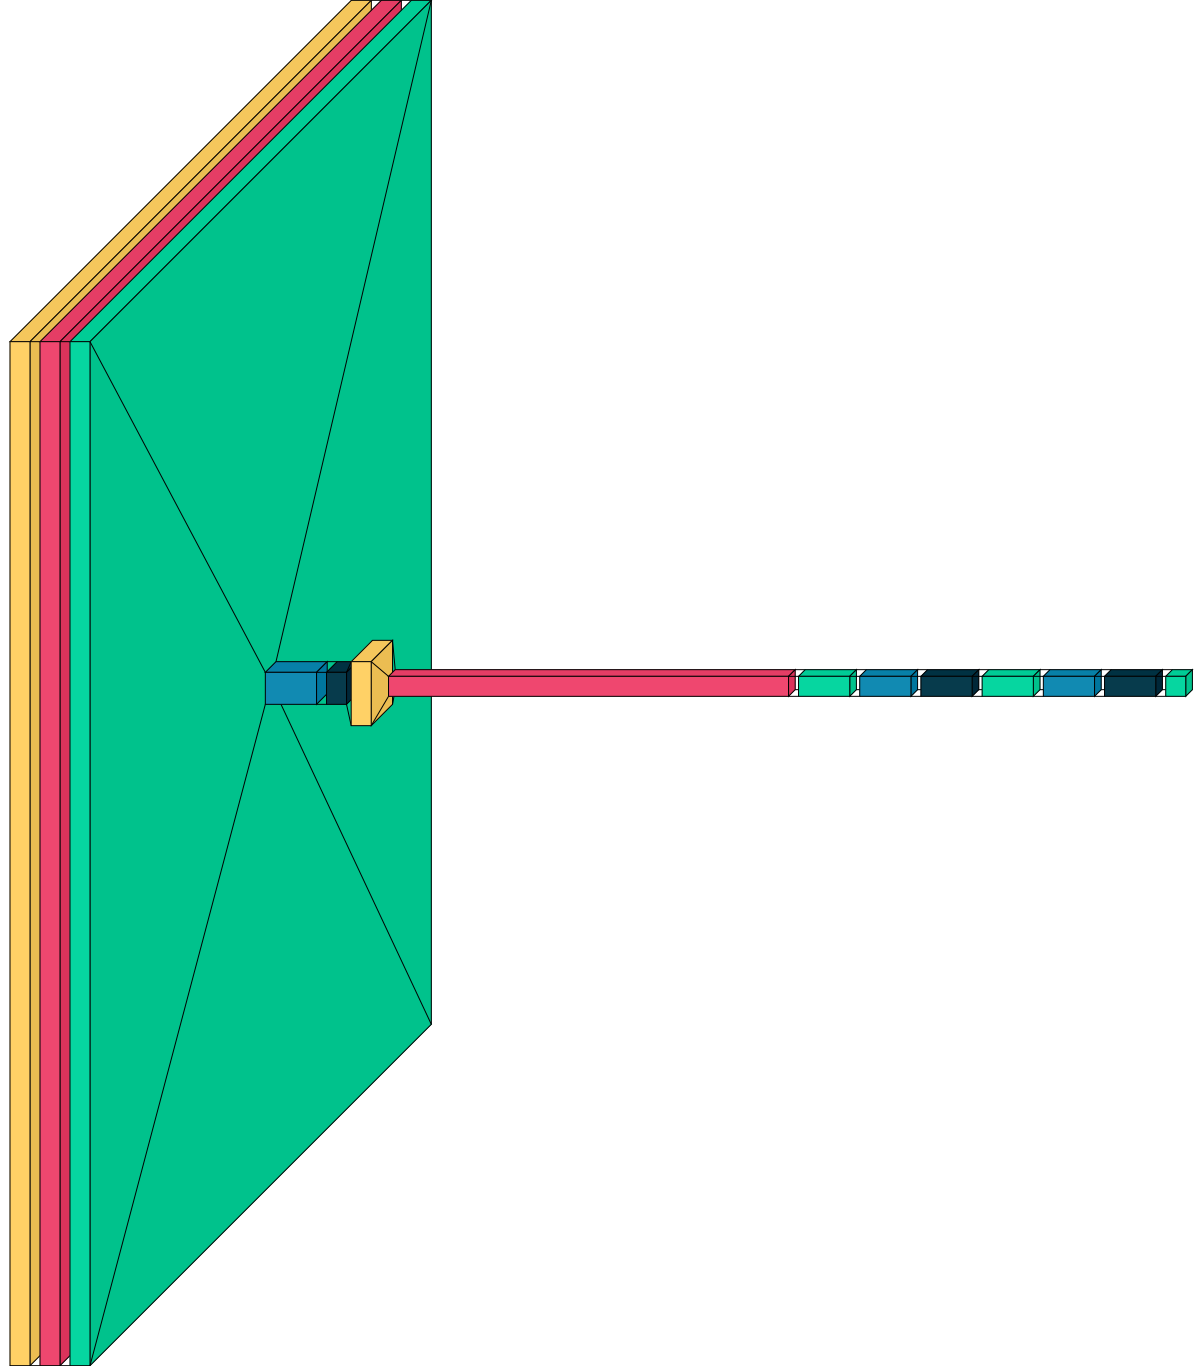

In [71]:
#Evaluate number of trainable and non-trainable parameters
trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in VGG_model.trainable_weights)
non_trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in VGG_model.non_trainable_weights)

#Print trainable and non-trainable parameters
print(f'The total number of trainable parameters is {trainable_params} and {non_trainable_params} Non-trainable parameters.')

#Visualize model architecture
visualkeras.layered_view(VGG_model, to_file='VGG_view.png')
#Visualize model hierarchy
#plot_model(model)

In [81]:
#Evaluate model on test data
VGG_test_loss, VGG_test_accuracy = VGG_model.evaluate(test_dataset)
print(f"Test loss: {VGG_test_loss:.4f}, Test accuracy: {VGG_test_accuracy:.4f}")

23/23 [==============================] - 3s 139ms/step - loss: 0.0436 - accuracy: 0.9887
Test loss: 0.0436, Test accuracy: 0.9887


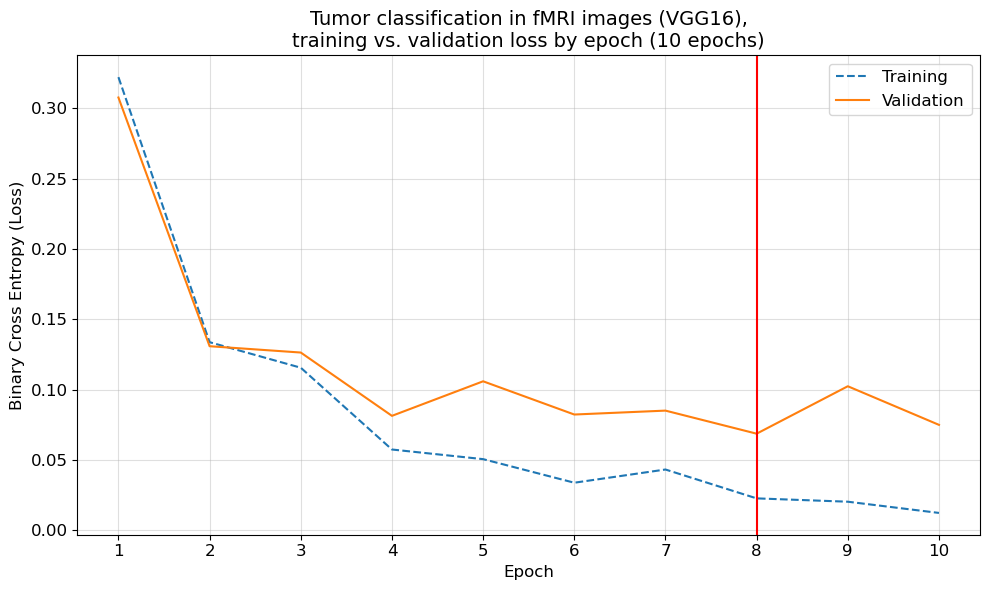

In [82]:
#Plot training and validation loss for VGG model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(VGG_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (VGG16),\ntraining vs. validation "
    "loss by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    VGG_history["loss"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    VGG_history["val_loss"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Binary Cross Entropy (Loss)", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(VGG_history['val_loss'])+1, c ='red', label="Callback model", color='r') 
plt.tight_layout()

In contrast the custom models I created, loss in this pretrained model quickly drops after 2 epochs and then plateaus for the rest of training. One notable feature of this plot is that after the 2nd epoch the training and validation loss diverge sharply which indicates the existence of overfitting. The red line indicates the best fitting model which is saved and reloaded.

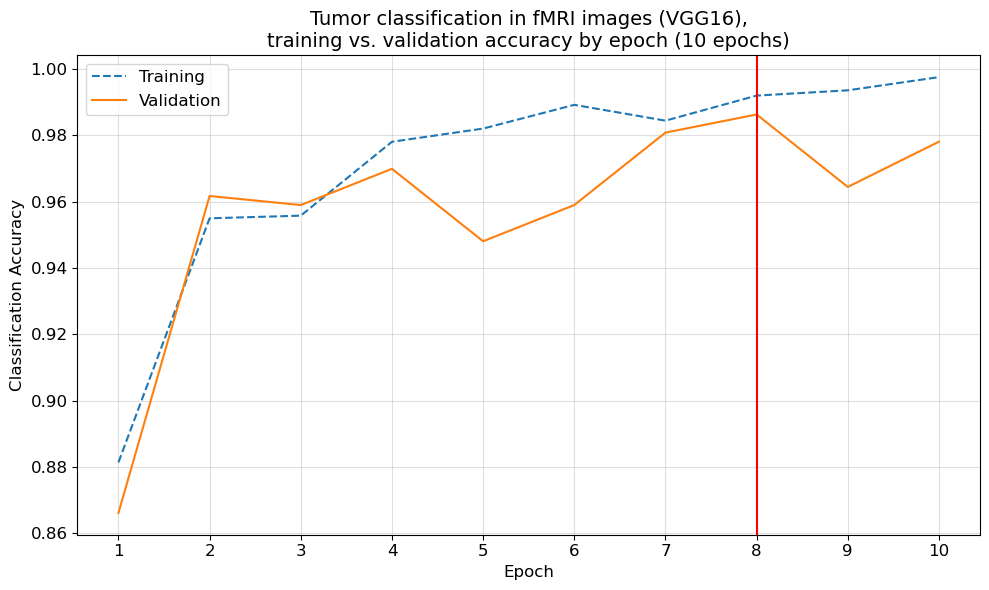

In [83]:
#Plot training and validation accuracy for VGG model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(VGG_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (VGG16),\ntraining vs. validation "
    "accuracy by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    VGG_history["accuracy"],
    "--",
    label="Training",
),\
plt.plot(
    x_axis_vals,
    VGG_history["val_accuracy"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Classification Accuracy", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(VGG_history['val_loss'])+1, c ='red', label="Callback model", color='r')     
plt.tight_layout()

Improvements in accuracy sharply occur after 2 epochs and then plateau for the rest of training. However, in contrast to the plot displaying training and validation loss, improvements in accuracy are still noticable after the first two epochs. Nevertheless, divergence between training and validation loss still indicates the existence of overfitting. The red line indicates the best fitting model which is saved and reloaded.

### GoogLeNet (Inception-V3)

Although VGG-16 is the predominant approach for evaluating colorectal tumors, GoogLeNet has been shown to obtain superior performance for tasks which involve learning features associated with brain abnormalities and using them for classification (Deepak & Ameer, 2019). Since our fMRI data depicts brains and we are looking for abnormalities, we decided to additionally evaluate this architecture for transfer learning.

In [84]:
#Load pre-trained GoogLeNet model and chop off top
base_model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
#Freeze GoogLeNet model weights
base_model.trainable = False
#Create input layer
input_layer = Input(shape=(256, 256, 1), name='Goog_input')
#Apply data augmentation
augmented = Lambda(augment_images)(input_layer)
#Add custom GrayscaleToRGB layer
rgb_layer = GrayscaleToRGBLayer()(augmented)

#Add base model after data augmentation
x = base_model(rgb_layer)

#Add convolutional layers
x = Conv2D(32, (1, 1), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = Conv2DTranspose(16, (3, 3), strides=(3, 3), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='valid', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)

#Add custom layers
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=109))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

#Create new Keras model
GoogLeNet_model = Model(inputs=input_layer, outputs=predictions)
K.clear_session() # Clear TensorFlow/Keras session (memory issues)

#Compile model
GoogLeNet_model.compile(optimizer=wadam, loss='binary_crossentropy', metrics=['accuracy'])

#Early stopping callback with patience = 5
Goo_early_5 = EarlyStopping(monitor='val_loss', patience=5,mode='min')
#Learning rate (plateau) scheduler
Goo_plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.0001)
#ModelCheckpoint callback to save the best model
Goo_BestFit = ModelCheckpoint(filepath='Goo_best_fit.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

#Load model (if it exists)
model_file = 'Goo_best_fit.h5'
if os.path.exists(model_file):
    print("Loading existing model")
    GoogLeNet_model = load_model(model_file)
    #Load training history from JSON file
    with open('Goog_history.json', 'r') as f:
        Goo_history = json.load(f)
else:
    print("Training new model")
    #Fit ~ VGG Model (if it doesn't exist)
    Goo_history = GoogLeNet_model.fit(train_dataset.batch(32), validation_data=val_dataset.batch(32), epochs=15, callbacks=[Goo_early_5, Goo_plateau_lr, Goo_BestFit])
    #Convert history to dictionary
    Goo_history = Goo_history.history
    #Save history to JSON file
    with open('Goog_history.json', 'w') as f:
        json.dump(Goo_history, f, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)
        #Line above necessary to fix issue with python float32 values.    
    #Save trained model
    GoogLeNet_model.save(model_file)
GoogLeNet_model.summary()

Training new model
Epoch 1/15
79/79 [==============================] - 18s 151ms/step - loss: 0.3384 - accuracy: 0.8583 - val_loss: 0.5217 - val_accuracy: 0.8005 - lr: 1.2500e-04
Epoch 2/15
79/79 [==============================] - 8s 99ms/step - loss: 0.1471 - accuracy: 0.9486 - val_loss: 0.1487 - val_accuracy: 0.9372 - lr: 1.2500e-04
Epoch 3/15
79/79 [==============================] - 8s 99ms/step - loss: 0.0787 - accuracy: 0.9697 - val_loss: 0.0815 - val_accuracy: 0.9727 - lr: 1.2500e-04
Epoch 4/15
79/79 [==============================] - 7s 88ms/step - loss: 0.0692 - accuracy: 0.9757 - val_loss: 0.1529 - val_accuracy: 0.9372 - lr: 1.2500e-04
Epoch 5/15
79/79 [==============================] - 8s 100ms/step - loss: 0.0539 - accuracy: 0.9825 - val_loss: 0.0691 - val_accuracy: 0.9809 - lr: 1.2500e-04
Epoch 6/15
79/79 [==============================] - 7s 88ms/step - loss: 0.0334 - accuracy: 0.9908 - val_loss: 0.0706 - val_accuracy: 0.9754 - lr: 1.2500e-04
Epoch 7/15
79/79 [============

The total number of trainable parameters is 1188417 and 21803808 Non-trainable parameters.


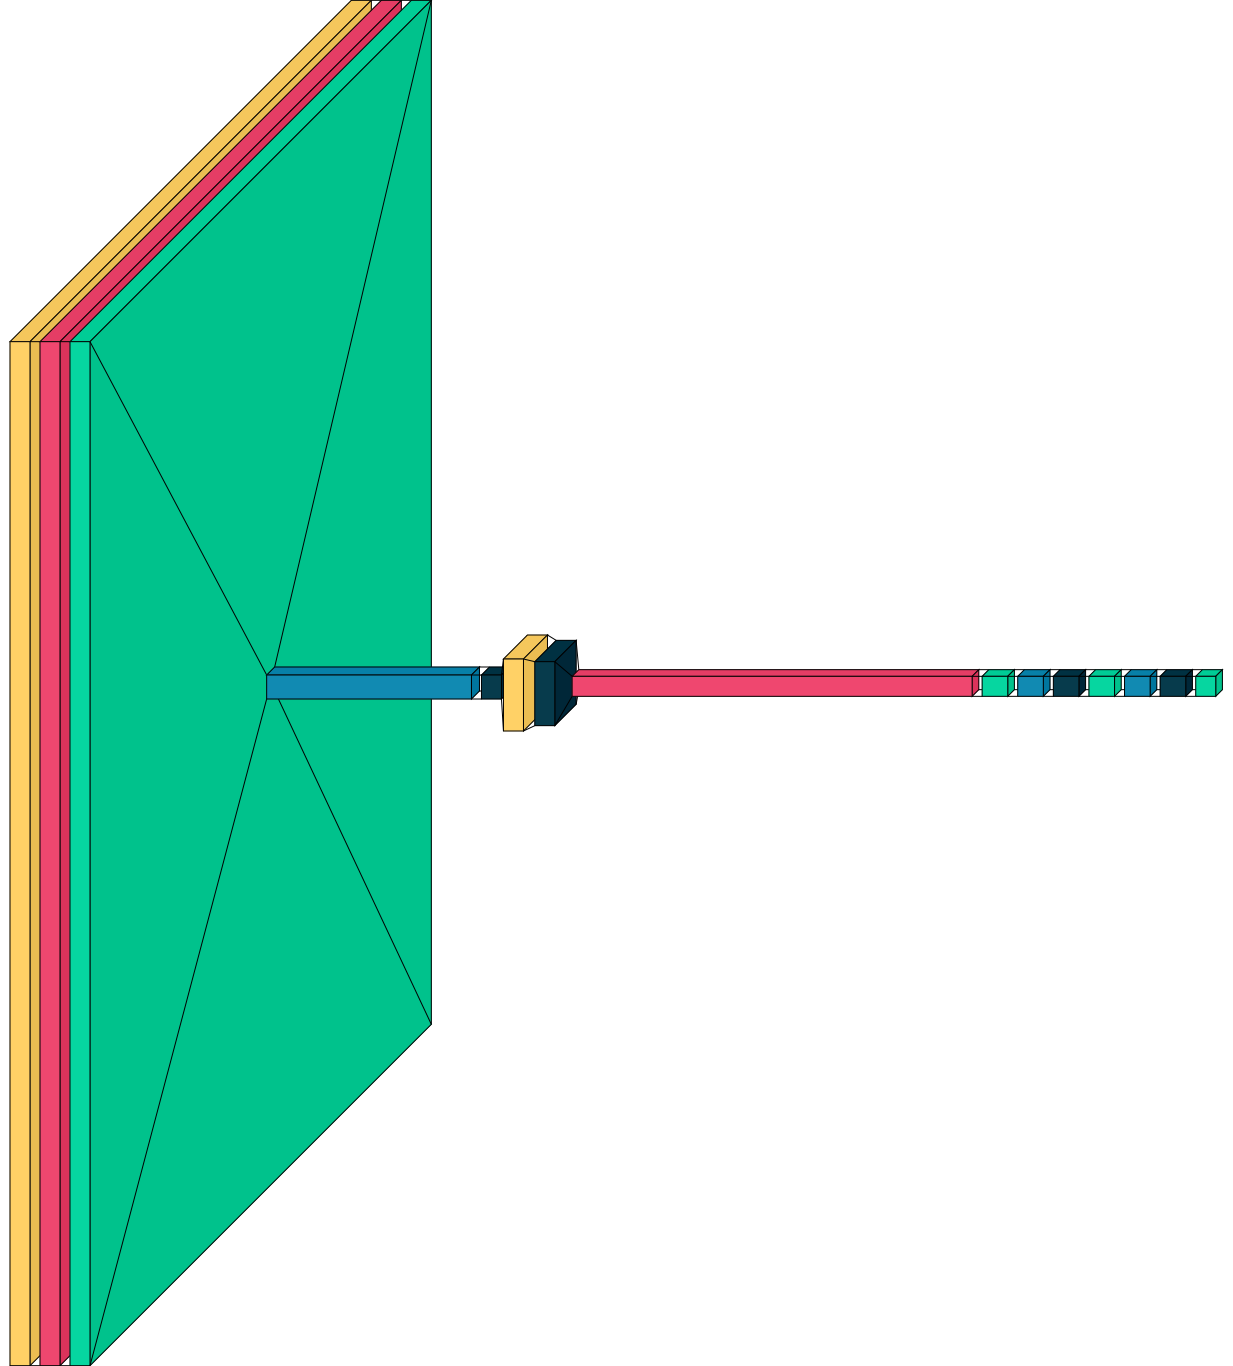

In [85]:
#Calculate number of trainable and non-trainable parameters
trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in GoogLeNet_model.trainable_weights)
non_trainable_params = sum(tf.reduce_prod(w.shape).numpy() for w in GoogLeNet_model.non_trainable_weights)

#Report number of trainable and non-trainable parameters
print(f'The total number of trainable parameters is {trainable_params} and {non_trainable_params} Non-trainable parameters.')

#Visualize model architecture
visualkeras.layered_view(GoogLeNet_model, to_file='GoogLeNet_view.png')
#Visualize model hierarchy
#plot_model(model)

In [86]:
# Evaluate the model on the test dataset
Goo_test_loss, Goo_test_accuracy = GoogLeNet_model.evaluate(test_dataset)
print(f" Test loss: {Goo_test_loss:.4f}, Test accuracy: {Goo_test_accuracy:.4f}")

23/23 [==============================] - 3s 123ms/step - loss: 0.0439 - accuracy: 0.9817
 Test loss: 0.0439, Test accuracy: 0.9817


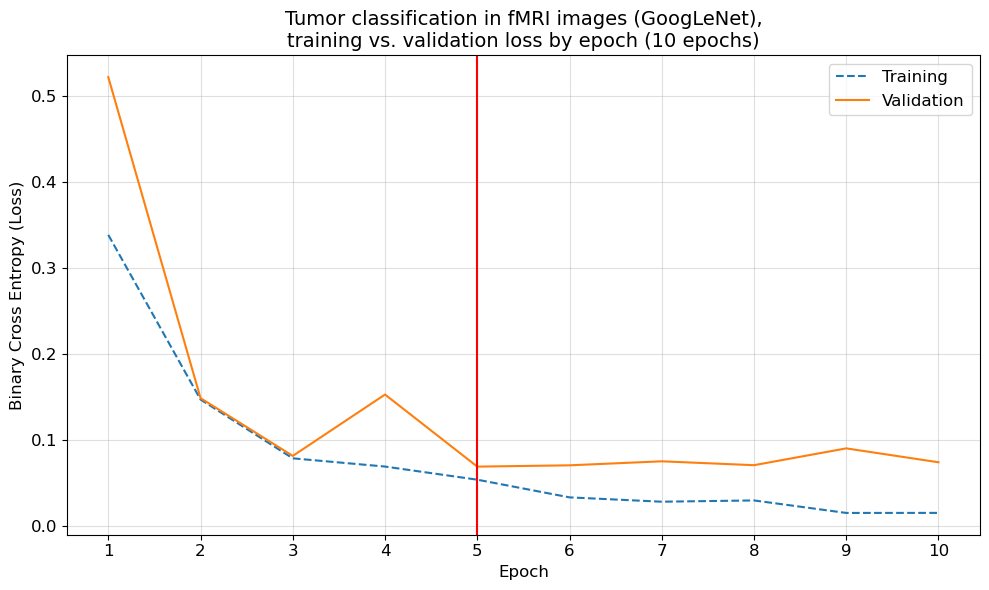

In [87]:
#Visualize training and test loss for GoogLeNet model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(Goo_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (GoogLeNet),\ntraining vs. validation "
    "loss by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    Goo_history["loss"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    Goo_history["val_loss"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Binary Cross Entropy (Loss)", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(Goo_history['val_loss'])+1, c ='red', label="Callback model", color='r')       
plt.tight_layout()

Training and validation loss rapidly decrease after 3 epochs and plateau thereafter until the end of training -- epoch 10. Critically, learning for the two datasets diverges after 3 epochs suggesting the presence of overfitting. The red line indicates the best fitting model which is saved and reloaded.

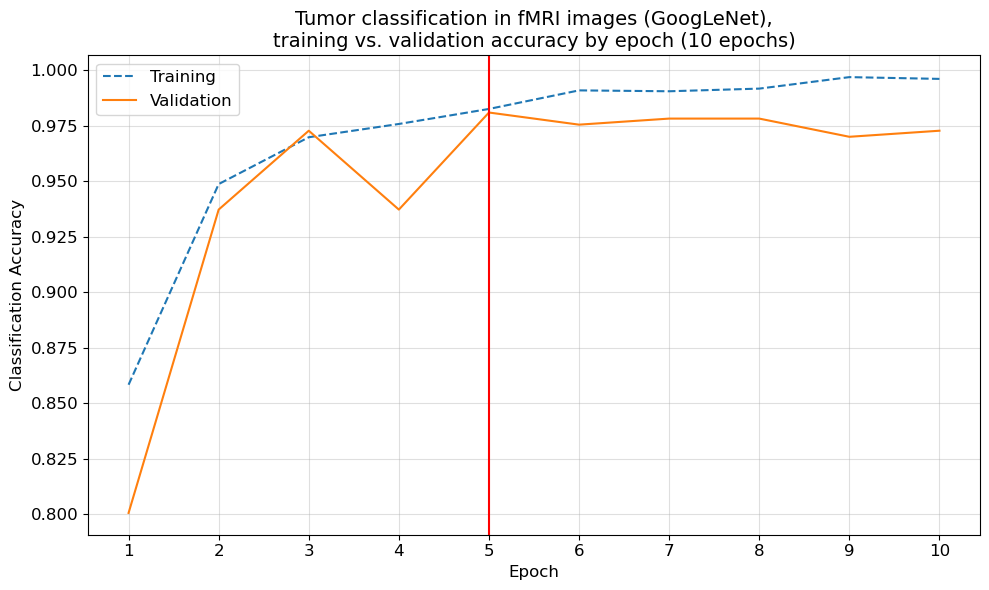

In [88]:
#Visualize training and validation accuracy for GoogLeNet model
fig, ax = plt.subplots(figsize=(10, 6))
x_axis_vals = np.array(range(len(Goo_history["accuracy"])))+1
plt.title(
    "Tumor classification in fMRI images (GoogLeNet),\ntraining vs. validation "
    "accuracy by epoch ({0:,} epochs)".format(
        len(x_axis_vals)
    ),
    fontsize=14,
)
plt.plot(
    x_axis_vals,
    Goo_history["accuracy"],
    "--",
    label="Training",
)
plt.plot(
    x_axis_vals,
    Goo_history["val_accuracy"],
    "-",
    label="Validation",
)
ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Classification Accuracy", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
ax.axvline(x=np.argmin(Goo_history['val_loss'])+1, c ='red', label="Callback model", color='r')    
plt.tight_layout()

Training and validation accuracy rapidly increase after 3 epochs and plateau thereafter until the end of training -- epoch 10. Critically, accuracy for the training data diverge after 3 epochs suggesting the presence of overfitting. The red line indicates the best fitting model which is saved and reloaded.

#### Takeaway:
Despite varying in architecture and number of parameters, the three models considered obtain comparable performance. Specifically, the loss of the VGG-16 model with 17.1 million parameters (0.436) was nearly equivalent to the loss of the GoogLeNet model with 23 million parameters (0.439), and both models had a higher loss than the best fitting custom model we created with 0.46 million parameters (0.0408). Moreover, although the GoogLeNet model had the worst accuracy (98.17%), this was within one percent of the best performing models: VGG-16 (98.87%) and the best fitting custom 'chocolate' model (98.87%). While VGG-16 and the chocolate model had an equivalent test accuracy I would still proceed with my chocolate model since it has 37x less parameters than the VGG-16 model and also possessed the lowest training loss. However, in order to make this decision empirical I will combine the predictions of these models in an ensemble and train this ensemble to investigate which model is preferred on the basis of model prediction weightings.

## Ensemble Model (VGG-16 / GoogLeNet / Chocolate)

In [69]:
#Define starting weights for each model
weights = tf.Variable([0.33, 0.33, 0.34], dtype=tf.float32, trainable=True)

#Make predictions for each model separately and save them
# Note: The reason I made the predictions seperate (and saved them) is because I was running into OOM issues.
def compute_and_save_predictions(model, dataset, output_filename, batch_size=32):
    predictions = []
    for X_batch, _ in dataset.batch(batch_size, drop_remainder=True):
        preds = model(X_batch)
        predictions.append(preds.numpy())
    predictions = np.vstack(predictions)
    np.save(output_filename, predictions)
    
#Define file names for saving
VGG_train_preds_file = 'VGG_train_preds.npy'
GoogLeNet_train_preds_file = 'GoogLeNet_train_preds.npy'
best_model_train_preds_file = 'best_model_train_preds.npy'

#Compute and save the predictions (if the files do not exist)
if not os.path.isfile(VGG_train_preds_file):
    compute_and_save_predictions(VGG_model, train_dataset, VGG_train_preds_file)
if not os.path.isfile(GoogLeNet_train_preds_file):
    compute_and_save_predictions(GoogLeNet_model, train_dataset, GoogLeNet_train_preds_file)
if not os.path.isfile(best_model_train_preds_file):
    compute_and_save_predictions(best_model, train_dataset, best_model_train_preds_file)

#Load saved predictions
VGG_train_preds = np.load(VGG_train_preds_file)
GoogLeNet_train_preds = np.load(GoogLeNet_train_preds_file)
best_model_train_preds = np.load(best_model_train_preds_file)

#Train ensemble model
def ensemble_predictions(weights, VGG_preds, GoogLeNet_preds, best_model_preds):
    return (
        weights[0] * VGG_preds +
        weights[1] * GoogLeNet_preds +
        weights[2] * best_model_preds
    )

#Define loss function
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))

#Define training hyper-parameters
epochs = 10
num_batches = len(train_dataset)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

#Create list to store losses and weights
weight_history = []
for epoch in range(epochs):
    train_loss = 0.0
    #Train Ensemble
    for i, (_, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            y_pred_train = ensemble_predictions(weights, VGG_train_preds, GoogLeNet_train_preds, best_model_train_preds)
            loss = compute_loss(y_batch, y_pred_train)
        gradients = tape.gradient(loss, [weights])
        optimizer.apply_gradients(zip(gradients, [weights]))
        train_loss += loss.numpy()
    train_loss /= num_batches #To caculate average loss
    #Append weights and loss to lists
    weight_history.append((weights.numpy().tolist(), train_loss))
    #Print results for feedback
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}")
#Determine weights which led to lowest loss (similar to callback)
best_weights = sorted(weight_history, key=lambda x: x[1])[0][0]

Epoch 1/10, Loss: 0.8417
Epoch 2/10, Loss: 0.8031
Epoch 3/10, Loss: 0.7971
Epoch 4/10, Loss: 0.7959
Epoch 5/10, Loss: 0.7961
Epoch 6/10, Loss: 0.7962
Epoch 7/10, Loss: 0.7959
Epoch 8/10, Loss: 0.7964
Epoch 9/10, Loss: 0.7966
Epoch 10/10, Loss: 0.7958


In [75]:
#Initialize ensemble weights as best from training
weights.assign(best_weights)

#Calculate total weight value
sum_weights = tf.reduce_sum(weights)

#Normalize weights
normalized_weights = weights / sum_weights

#Convert tensor to list
normalized_weights = normalized_weights.numpy().tolist()

#Report values in f-string
print(f"The weighting associated with each model was {np.round(normalized_weights[0], 3)*100}% VGG16, {np.round(normalized_weights[1], 3)*100}% GoogLeNet, and {np.round(normalized_weights[2],3)*100}% my best fitting model")

The weighting associated with each model was 22.3% VGG16, 23.1% GoogLeNet, and 54.6% my best fitting model


#### Takeaway:
The output of this analysis suggests the custom 'chocolate' model I created was the best performing model within the ensemble. One reason this may be so is because the test loss associated with this model was the lowest. Alternatively, another possibility is that this model performed best as it was specialied for the current task. Whatever the reason, we will continue to utilize the chocolate model by examining it's smoothed gradient saliency map to investigate what information the model considers when reaching a classification decision.

## Best Fitting Model - Saliency Map

In [233]:
#Select image from test data
test_image = next(iter(test_dataset.take(1)))[0][0:1]

#Create gradient model from best fitting 'chocolate' model
grad_model = tf.keras.models.Model(inputs=best_model.inputs, outputs=best_model.output)

#Define hyperparameters for saliency map
num_samples = 50
noise_level = 0.1

#Calculate gradients
grads_accumulated = np.zeros(test_image.shape)
for _ in range(num_samples):
    with tf.GradientTape() as tape:
        tape.watch(test_image) #Evaluate gradients relative to an image
        noise = noise_level * np.random.normal(size=test_image.shape) #For smoothing
        noisy_image = test_image + noise
        predictions = grad_model(noisy_image)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, test_image)
    grads_accumulated += grads.numpy()

#Average gradients (for heatmap)
avg_grad = grads_accumulated / num_samples

#Generate heatmap
heatmap = np.max(np.abs(avg_grad), axis=-1)
heatmap /= np.max(heatmap)

#Apply threshold to heatmap (too much noise without)
threshold = 0.35
heatmap[heatmap < threshold] = 0

#Convert heatmap to uint8 format (errors if I don't)
heatmap = np.uint8(255 * heatmap)
heatmap = np.squeeze(heatmap)

#Convert image to 3-channel image to combine with heatmap
orig_img = test_image.numpy()[0]
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2BGR)
orig_img = np.uint8(255 * orig_img)

#Define colors for heatmap
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#Resize heatmap (to match the original image dimensions)
heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

#Overlay resized heatmap on image
superimposed_img = cv2.addWeighted(orig_img, 0.5, heatmap_resized, 0.5, 0)

2023-05-06 22:25:51.184052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [711]
	 [[{{node Placeholder/_1}}]]
2023-05-06 22:25:51.184578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [711,256,256,1]
	 [[{{node Placeholder/_0}}]]


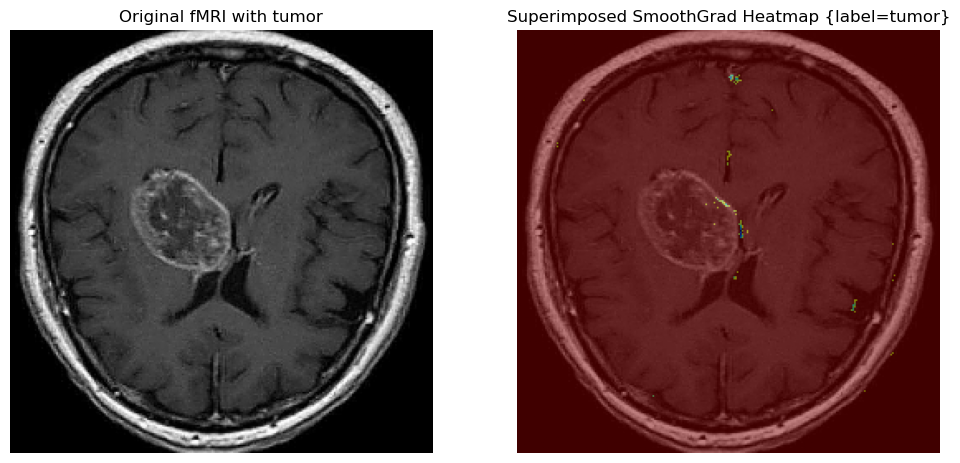

In [237]:
#Normalize image
normalized_orig_img = orig_img / 255.0

#Plot original image
plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)
plt.imshow(normalized_orig_img, cmap='gray')
plt.title('Original fMRI with tumor') 
plt.axis('off')
#Plot superimposed image
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img / 255.0)
plt.title('Superimposed SmoothGrad Heatmap {label=tumor}')
plt.axis('off')
plt.show()

I selected the photo above since I was surprised by how effective the output was. Specifically, there is a large tumor in the image which is what captured my attention -- ie. as a neurosurgeon I would immediately identify the mass as a tumor. However, what surprised me about the saliency map associated with this image is that the chocolate model also identified a tumor at the top of the image which I missed on my initial evaluation of the original image. Moreover, as is apparent from the colored pixels in the smoothgrad heatmap, the convolutional neural network does not only identify the large tumor, and the smaller hidden tumor, it also focuses on abnormalities in the brain such as regions with brain atrophy when making decisions. This is not something I expected, but is brilliant because tumors cause deformations of brain matter beyond where they are localized -- thus, the model not only identifies malignant brain tumors, but also comorbidities associated with the presence of brain tumors.

## Summary

In order to evaluate the effectiveness of our model training beyond our current results, we can also compare our results to previous efforts. Previously, researchers from Korea used the same Br35H dataset as us and leveraged transfer learning by creating an ensemble of deep features. Specifically, they extracted features from images using 13 pre-trained deep convolutional neural networks with ML classifiers (VGG-16, ResNet-50, Inception V3, DenseNet-121, MobileNet, etc.) and combined predictions from the 3 best pretrained models for feature extraction (Kang, Ullah, & Gwak, 2021). Ultimately the researchers settled on a combination of DenseNet-169 + Shufflenet + MnasNet; however, even with this optimized ensemble the accuracy of the ensemble for binary classification was  98.83%., slightly below the accuracy (98.87) of the best fitting model we trained with an autoencoder structure. It is difficult to conclusively identify what may have resulted in the better performance of our model, but one interesting shared design choice was that we independently settled on the same data augmentation procedure as these researchers (rotation and horizontal flip), but constrained our rotation to a more conservative range we considered 'plausible' -- ie. 9 degrees of rotation, not 90 like these researchers. Additionally, these researchers used a 80-20 training-test split, but we used a 70-20-10 training-validation-test split of the Br35H dataset and supplamented our data with 589 additional images. Whatever the difference, the performance of our model is notable as...

## Future Directions:

Ensemble learning was incredibly challenging with the current model architectures. I tried several configurations to combine the models including custom layers which combine the tensor outputs prior to the flatten layer (configured to be the same dimensions), and agregating the predictions made by each model with a custom cost function -- but both attempts involved far more memory than available on jupyterhub so I ran into several OOM errors. Ultimately I ended up turning the problem into a regression type problem and estimated the weights by optimizing over the three model predictions, but given more memory I would like to actually create an ensemble of the three models so everything can be optimized together. Additionally, I tried using tensorboard to examine the floating point operations associated each model, but I ran into administrator privelege issues on jupyter-hub so in the future I would like to gain permission to execute tensorboard on jupyterhub so I can gain more experience using Tensorboard.

### Extras:
I also applied k-fold cross validation to the best model I created (non-transfer learning) to optimize the learning rates for adam_w, but what I observed is despite converging on different combinations between the two, the test performance did not improve across the various iterations -- which highlights just how optimally adamW learns optimal learning rates and weight decay for this problem.

## References
1) Miller, KD, Ostrom, QT, Kruchko, C, Patil, N, Tihan, T, Cioffi, G, Fuchs, HE, Waite, KA, Jemal, A, Siegel, RL, 
    Barnholtz-Sloan, JS (2021). Brain and other central nervous system tumor statistics. CA Cancer J Clin, 2021.
    https://doi.org/10.3322/caac.21693

2) Odena, et al., "Deconvolution and Checkerboard Artifacts", Distill, 2016. http://doi.org/10.23915/distill.00003

3) Arabahmadi, M., Farahbakhsh, R., & Rezazadeh, J. (2022). Deep Learning for Smart Healthcare-A Survey on Brain 
    Tumor Detection from Medical Imaging. Sensors (Basel, Switzerland), 22(5), 1960. https://doi.org/10.3390/s22051960
        
4) Deepak, S., & Ameer, P.M. (2019). Brain tumor classification using deep CNN features via transfer learning. 
    Computers in biology and medicine, 111, 103345 .